<a href="https://colab.research.google.com/github/Breno-Valle/Statistical-and-Clustering-Analysis-of-Galaxies/blob/main/COMBO_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalation and Imports

In [1]:
pip install kneed

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator

import scipy
import scipy.cluster.hierarchy as shc
from scipy.stats import shapiro, boxcox, t, mannwhitneyu
from statistics import stdev
from math import sqrt
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#The dataset

In [3]:
combo = pd.read_csv('/content/COMBO17.csv')

In [4]:
combo.head()

,Nr,Rmag,e.Rmag,ApDRmag,mumax,Mcz,e.Mcz,MCzml,chi2red,UjMAG,e.UjMAG,BjMAG,e.BjMAG,VjMAG,e.VjMAG,usMAG,e.usMAG,gsMAG,e.gsMAG,rsMAG,e.rsMAG,UbMAG,e.UbMAG,BbMAG,e.BbMAG,VnMAG,e.VbMAG,S280MAG,e.S280MA,W420FE,e.W420FE,W462FE,e.W462FE,W485FD,e.W485FD,W518FE,e.W518FE,W571FS,e.W571FS,W604FE,e.W604FE,W646FD,e.W646FD,W696FE,e.W696FE,W753FE,e.W753FE,W815FS,e.W815FS,W856FD,e.W856FD,W914FD,e.W914FD,W914FE,e.W914FE,UFS,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD
0,6,24.995,0.097,0.935,24.214,0.832,0.036,1.400,0.64,-17.67,0.14,-17.54,0.25,-17.76,0.25,-17.83,0.14,-17.60,0.25,-17.97,0.25,-17.76,0.14,-17.53,0.25,-17.76,0.25,-18.22,0.17,0.000660,3.85E-03,0.01270,0.00372,0.01890,0.00448,0.018200,0.00355,0.01470,0.00301,0.01660,0.00409,0.018800,0.00563,0.02460,0.00351,0.02450,0.00524,0.02160,0.00266,0.02440,0.00546,0.0377,0.00610,0.01170,0.0101,0.01870,0.00239,0.01630,0.00129,0.017300,0.00141,0.01650,0.000434,0.02470,0.00483
1,9,25.013,0.181,-0.135,25.303,0.927,0.122,0.864,0.41,-18.28,0.22,17.86,0.55,-18.20,0.55,-18.42,0.22,-17.96,0.55,-18.43,0.55,-18.36,0.22,-17.85,0.55,-18.19,0.55,-17.97,0.54,0.000324,3.19E-03,0.00514,0.00323,0.00273,0.00485,0.000785,0.00485,0.00991,0.00284,0.00905,0.00445,0.002980,0.00892,0.00983,0.00343,0.01420,0.00527,0.01470,0.00308,0.01140,0.00627,0.0103,0.00646,0.02630,0.0148,0.00706,0.00238,0.00420,0.00115,0.003930,0.00182,0.00723,0.000500,0.00973,0.00460
2,16,24.246,0.054,0.821,23.511,1.202,0.037,1.217,0.92,-19.75,0.14,-19.91,0.14,-20.41,0.14,-19.87,0.14,-20.05,0.14,-20.71,0.14,-19.82,0.14,-19.89,0.14,-20.40,0.14,-19.77,0.12,0.013000,4.11E-03,0.01970,0.00432,0.02550,0.00428,0.015900,0.00464,0.02290,0.00455,0.02340,0.00374,0.023100,0.00667,0.02720,0.00405,0.03540,0.00456,0.04530,0.00360,0.07810,0.00658,0.0711,0.00613,0.06410,0.0127,0.01260,0.00184,0.01830,0.00115,0.018800,0.00167,0.02880,0.000655,0.05700,0.00465
3,21,25.203,0.128,0.639,24.948,0.912,0.177,0.776,0.39,-17.83,0.17,-17.39,0.31,-17.67,0.31,-17.98,0.17,-17.47,0.31,-17.89,0.31,-17.92,0.17,-17.38,0.31,-17.67,0.31,-18.12,0.28,0.011900,2.70E-03,0.01590,0.00314,0.00156,0.00493,0.002610,0.00476,0.00176,0.00310,0.00916,0.00332,0.006330,0.00596,0.01230,0.00248,0.00225,0.00692,0.01690,0.00276,0.00875,0.00672,0.0070,0.00557,0.00587,0.0114,0.01410,0.00186,0.01180,0.00110,0.009670,0.00204,0.01050,0.000416,0.01340,0.00330
4,26,25.504,0.112,-1.588,24.934,0.848,0.067,1.330,1.45,-17.69,0.42,-18.40,0.83,-19.37,0.83,-17.81,0.42,-18.69,0.83,-19.88,0.83,-17.76,0.42,-18.35,0.83,-19.37,0.83,-13.93,45.11,0.001350,3.71E-03,0.00509,0.00268,0.00185,0.00401,0.009960,0.00432,0.00344,0.00448,0.00632,0.00366,-0.000184,0.01240,0.00554,0.00293,0.01620,0.00497,0.00676,0.00314,0.01020,0.00610,0.0133,0.00682,0.01990,0.0103,0.00514,0.00170,0.00102,0.00127,0.000039,0.00160,0.00139,0.000499,0.00590,0.00444


## Changing feature names to better understanding

In [5]:
combo = combo.rename(columns={ 'UjMAG': 'UVmag', 'BjMAG': 'Bluemag', 'VjMAG': 'Opticmag',
        'W420FE': 'lenwave1', 'W462FE': 'lenwave2', 'W485FD': 'lenwave3',
       'W518FE': 'lenwave4', 'W571FS': 'lenwave5', 'W604FE': 'lenwave6',
       'W646FD': 'lenwave7', 'W696FE': 'lenwave8','W753FE': 'lenwave9',
        'W815FS': 'lenwave10',  'W856FD': 'lenwave11', 'W914FD': 'lenwave12',
        'W914FE': 'lenwave13', 'UFS	': 'UVfilter', 'BFS': 'BLUEfilter', 'VFD': 'OPTICfilter', 'RFS': 'REDfilter', 'IFD': 'InfraREdfilter'})

In [6]:
combo.head(2)

,Nr,Rmag,e.Rmag,ApDRmag,mumax,Mcz,e.Mcz,MCzml,chi2red,UVmag,e.UjMAG,Bluemag,e.BjMAG,Opticmag,e.VjMAG,usMAG,e.usMAG,gsMAG,e.gsMAG,rsMAG,e.rsMAG,UbMAG,e.UbMAG,BbMAG,e.BbMAG,VnMAG,e.VbMAG,S280MAG,e.S280MA,lenwave1,e.W420FE,lenwave2,e.W462FE,lenwave3,e.W485FD,lenwave4,e.W518FE,lenwave5,e.W571FS,lenwave6,e.W604FE,lenwave7,e.W646FD,lenwave8,e.W696FE,lenwave9,e.W753FE,lenwave10,e.W815FS,lenwave11,e.W856FD,lenwave12,e.W914FD,lenwave13,e.W914FE,UFS,e.UFS,BLUEfilter,e.BFS,OPTICfilter,e.VFD,REDfilter,e.RFS,InfraREdfilter,e.IFD
0,6,24.995,0.097,0.935,24.214,0.832,0.036,1.400,0.64,-17.67,0.14,-17.54,0.25,-17.76,0.25,-17.83,0.14,-17.60,0.25,-17.97,0.25,-17.76,0.14,-17.53,0.25,-17.76,0.25,-18.22,0.17,0.000660,3.85E-03,0.01270,0.00372,0.01890,0.00448,0.018200,0.00355,0.01470,0.00301,0.01660,0.00409,0.01880,0.00563,0.02460,0.00351,0.0245,0.00524,0.0216,0.00266,0.0244,0.00546,0.0377,0.00610,0.0117,0.0101,0.01870,0.00239,0.0163,0.00129,0.01730,0.00141,0.01650,0.000434,0.02470,0.00483
1,9,25.013,0.181,-0.135,25.303,0.927,0.122,0.864,0.41,-18.28,0.22,17.86,0.55,-18.20,0.55,-18.42,0.22,-17.96,0.55,-18.43,0.55,-18.36,0.22,-17.85,0.55,-18.19,0.55,-17.97,0.54,0.000324,3.19E-03,0.00514,0.00323,0.00273,0.00485,0.000785,0.00485,0.00991,0.00284,0.00905,0.00445,0.00298,0.00892,0.00983,0.00343,0.0142,0.00527,0.0147,0.00308,0.0114,0.00627,0.0103,0.00646,0.0263,0.0148,0.00706,0.00238,0.0042,0.00115,0.00393,0.00182,0.00723,0.000500,0.00973,0.00460


##Exploratory Data Analysis 

In [7]:
combo.shape

(3462, 65)

In [8]:
for c in combo.isnull().sum() / combo.shape[0]:
  print(c)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00028885037550548814
0.00028885037550548814
0.006932409012131715
0.006932409012131715
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [9]:
combo = combo.dropna()
combo.shape

(3438, 65)

In [10]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3438 entries, 0 to 3461
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nr              3438 non-null   int64  
 1   Rmag            3438 non-null   float64
 2   e.Rmag          3438 non-null   float64
 3   ApDRmag         3438 non-null   float64
 4   mumax           3438 non-null   float64
 5   Mcz             3438 non-null   float64
 6   e.Mcz           3438 non-null   float64
 7   MCzml           3438 non-null   float64
 8   chi2red         3438 non-null   float64
 9   UVmag           3438 non-null   float64
 10  e.UjMAG         3438 non-null   float64
 11  Bluemag         3438 non-null   float64
 12  e.BjMAG         3438 non-null   float64
 13  Opticmag        3438 non-null   float64
 14  e.VjMAG         3438 non-null   float64
 15  usMAG           3438 non-null   float64
 16  e.usMAG         3438 non-null   float64
 17  gsMAG           3438 non-null   f

### Dropping not very usefull features to us

In [11]:
error_features = []
for feature in combo.columns:
  if feature[0] == 'e':
    error_features.append(feature)

In [12]:
combo = combo.drop(error_features, axis=1)

In [13]:
combo.columns

Index(['Nr', 'Rmag', 'ApDRmag', 'mumax', 'Mcz', 'MCzml', 'chi2red', 'UVmag',
       'Bluemag', 'Opticmag', 'usMAG', 'gsMAG', 'rsMAG', 'UbMAG', 'BbMAG',
       'VnMAG', 'S280MAG', 'lenwave1', 'lenwave2', 'lenwave3', 'lenwave4',
       'lenwave5', 'lenwave6', 'lenwave7', 'lenwave8', 'lenwave9', 'lenwave10',
       'lenwave11', 'lenwave12', 'lenwave13', 'UFS', 'BLUEfilter',
       'OPTICfilter', 'REDfilter', 'InfraREdfilter'],
      dtype='object')

### Describe and Relaation inside data  

In [14]:
combo.describe()

,Nr,Rmag,ApDRmag,mumax,Mcz,MCzml,chi2red,UVmag,Bluemag,Opticmag,usMAG,gsMAG,rsMAG,UbMAG,BbMAG,VnMAG,S280MAG,lenwave1,lenwave2,lenwave3,lenwave4,lenwave5,lenwave6,lenwave7,lenwave8,lenwave9,lenwave10,lenwave11,lenwave12,lenwave13,UFS,BLUEfilter,OPTICfilter,REDfilter,InfraREdfilter
count,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000,3438.000000
mean,5104.566318,23.927276,-0.191575,24.174913,0.728060,0.768744,1.167301,-17.875364,-17.755457,-18.117100,-18.025864,-17.854724,-18.387350,-17.962167,-17.746451,-18.112752,-18.011504,-0.128639,0.025871,0.023734,0.029240,0.034442,0.037519,0.039091,0.043280,0.047726,0.049286,0.053069,0.053145,0.058671,0.016058,0.022022,0.029719,0.039295,0.048758
std,2823.126642,1.431727,0.451852,1.016630,0.319235,0.375530,0.683159,1.964481,2.121079,2.091325,1.959857,2.051874,2.102603,1.962827,2.030544,2.091630,1.947664,0.896083,0.073251,0.078162,0.109243,0.134764,0.153870,0.154357,0.173165,0.184068,0.183322,0.194244,0.203215,0.205105,0.025423,0.064389,0.119424,0.164594,0.188317
min,6.000000,16.572000,-4.700000,18.112000,0.007000,0.000000,0.140000,-23.210000,-23.150000,-23.620000,-23.330000,-23.280000,-23.940000,-23.280000,-23.130000,-23.620000,-23.590000,-9.990000,-0.023800,-0.012300,-0.006250,-0.006320,-0.005810,-0.022100,-0.004560,-0.006390,-0.001770,-0.014700,-0.016300,-0.021300,-0.002430,-0.001040,0.000019,0.000912,0.000056
25%,2666.750000,23.094750,-0.425000,23.616000,0.517500,0.501250,0.730000,-19.080000,-19.020000,-19.420000,-19.230000,-19.120000,-19.690000,-19.170000,-19.000000,-19.420000,-19.230000,0.006090,0.007830,0.005970,0.007533,0.008420,0.008350,0.008990,0.009442,0.012125,0.011900,0.014200,0.012500,0.017125,0.006170,0.005663,0.005980,0.006950,0.011000
50%,5175.500000,24.057000,-0.141000,24.381500,0.809000,0.825000,1.020000,-18.220000,-18.140000,-18.460000,-18.370000,-18.220000,-18.715000,-18.310000,-18.120000,-18.460000,-18.365000,0.011200,0.013600,0.011400,0.013200,0.014400,0.015100,0.017900,0.016700,0.019900,0.019300,0.024100,0.022600,0.029300,0.010200,0.010400,0.011800,0.014050,0.019200
75%,7493.500000,25.015750,0.088000,24.946000,0.982000,1.024000,1.440000,-17.320000,-17.072500,-17.420000,-17.460000,-17.160000,-17.642500,-17.400000,-17.052500,-17.410000,-17.340000,0.019600,0.023875,0.021100,0.024200,0.026975,0.028675,0.032900,0.033900,0.037400,0.038975,0.044075,0.043300,0.051200,0.017600,0.020175,0.023600,0.029800,0.039300
max,9997.000000,26.954000,1.462000,25.833000,1.379000,1.400000,11.910000,-7.910000,17.860000,-7.830000,-8.090000,-7.710000,-8.050000,-8.010000,-7.570000,-7.830000,-8.500000,0.837000,1.820000,1.900000,2.920000,3.950000,4.240000,4.290000,4.930000,4.970000,5.150000,5.170000,5.740000,5.740000,0.410000,1.470000,3.170000,4.630000,5.290000


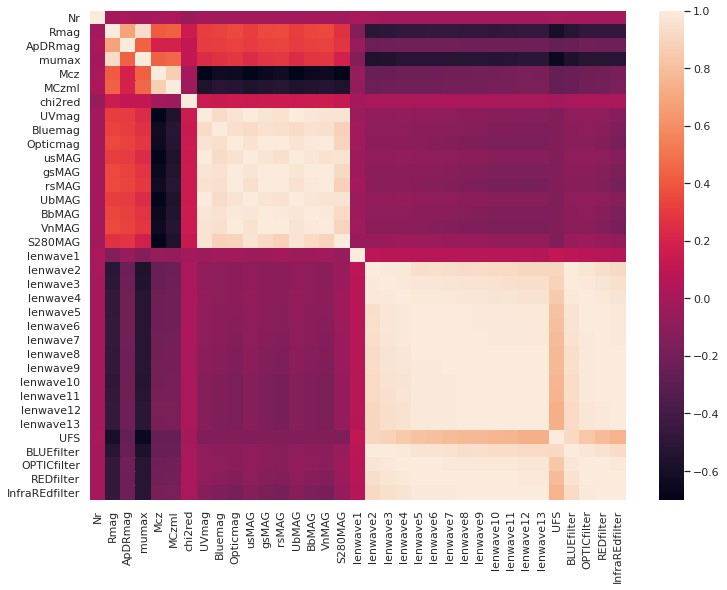

In [15]:
plt.figure(figsize=(12,9))
sns.heatmap(combo.corr())

## Understanding the three main variables

Working with three main features

- Rmag (Red Magnetude - Bright)

- ApDRmag (Size)

- Mcz (redshift - Distance)

This features can e analysed as main properties of the galaxies, so let's see how they are related to eac other, and try to find some interesting pattern.

In [16]:
#defining a function of find the Person Correlation and the R square of each combination of features
def find_corr_galaxy(x=0, y=0):
  corr_matrix = np.corrcoef(x, y)
  pearson_corr_galaxy = corr_matrix[0,1]
  r2_galaxy = pearson_corr_galaxy ** 2
  return pearson_corr_galaxy, r2_galaxy

In [17]:
#as we can see, there is a good correlation between this two features, and also a strong R2
#that means 47% of the variance in one features can be explnaed by the variance  in the other one
pearson_corr, r2 = find_corr_galaxy(x=combo.Rmag, y=combo.ApDRmag)
print(f'Pearson Correlation Bright vs Size: {pearson_corr:.2f}')
print(f'R2: {r2:.2f}')

Pearson Correlation Bright vs Size: 0.68
R2: 0.47


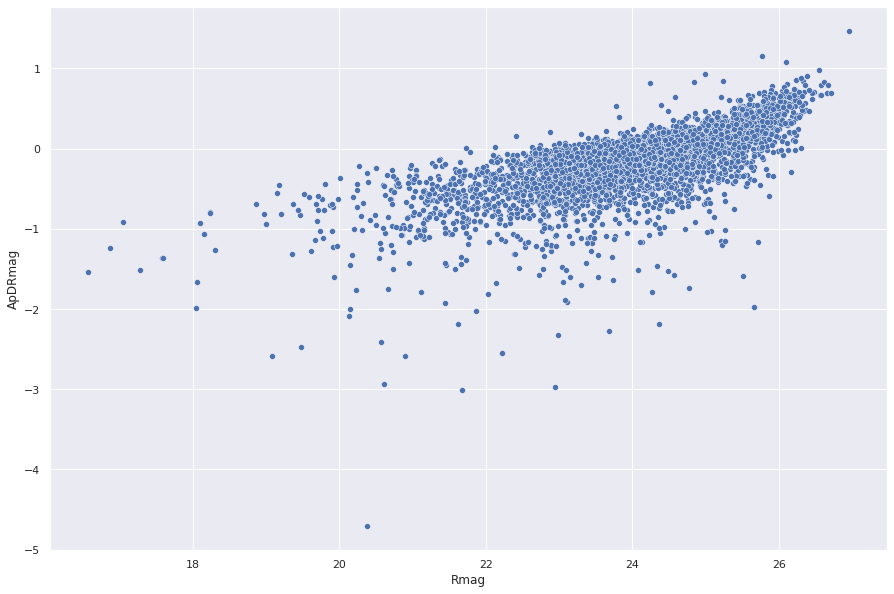

In [18]:
#ploting this correlation helps us to a better understanding of the situation 
plt.figure(figsize=(15,10))
sns.scatterplot(x='Rmag', y='ApDRmag', data=combo)

In [19]:
#here its clearly that the correlation is not that strong
#only 4% of the variance in the size can be explaned by the distance of the galaxy from us
pearson_corr, r2 = find_corr_galaxy(x=combo.Mcz, y=combo.ApDRmag)
print(f'Pearson Correlation Distance vs Size: {pearson_corr:.2f}')
print(f'R2: {r2:.2f}')

Pearson Correlation Distance vs Size: 0.19
R2: 0.04


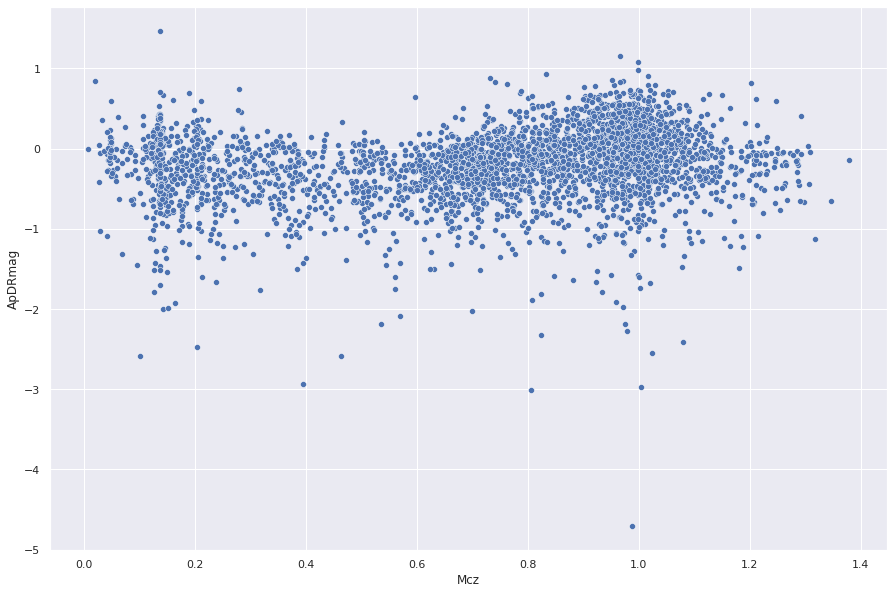

In [20]:
#ploting this correlation its clear that the correlation is weak
#but still it looks like a tendency
plt.figure(figsize=(15,10))
sns.scatterplot(x=combo.Mcz,y=combo.ApDRmag)

In [21]:
#and we have a reasonable between color and bright 
pearson_corr, r2 = find_corr_galaxy(x=combo.Mcz, y=combo.Rmag)
print(f'Pearson Correlation Distance vs Bright {pearson_corr:.2f}')
print(f'R2: {r2:.2f}')

Pearson Correlation Distance vs Bright 0.42
R2: 0.17


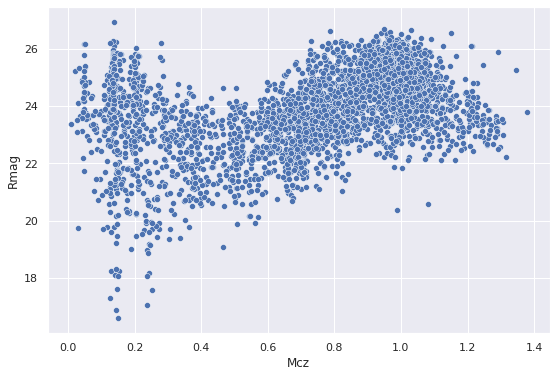

In [22]:
plt.figure(figsize=(9,6))
sns.scatterplot(x=combo.Mcz,y=combo.Rmag)

Relationship Bright x lenght wave

- A interesting point to be known is that more bright the galaxy is more intense will be the emission of eletromagnetic waves, and we can take a look if this happen hear ploting the Magnitude of the galaxy but the intensity of fotons that are recived here for each length wave.

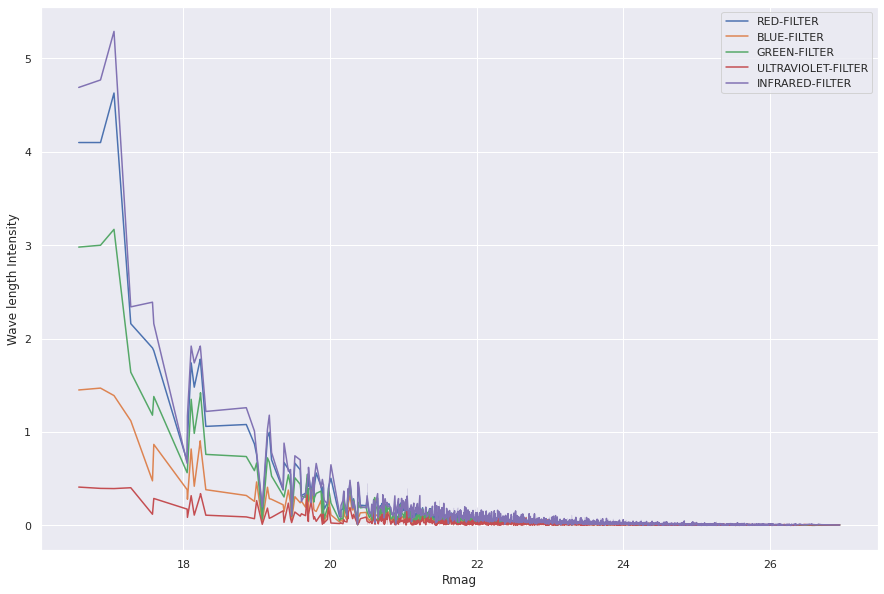

In [23]:
#deffining a function to plot all the length waves by magnitude
def plot_lenwave(column_name): 
  plt.figure(figsize=(15,10))

  sns.lineplot(x = combo[column_name], y = combo['REDfilter'], palette = 'red', label = 'RED-FILTER' )
  sns.lineplot(x = combo[column_name], y = combo['BLUEfilter'], palette = 'blue', label = 'BLUE-FILTER')
  sns.lineplot(x = combo[column_name], y = combo['OPTICfilter'], palette = 'green', label = 'GREEN-FILTER')
  sns.lineplot(x = combo[column_name], y = combo['UFS'], palette = 'Purple', label = 'ULTRAVIOLET-FILTER')
  sns.lineplot(x= combo[column_name], y = combo['InfraREdfilter'], palette = 'yellow', label = 'INFRARED-FILTER')
  plt.ylabel('Wave length Intensity')
  plt.legend()
plot_lenwave(column_name = 'Rmag')

The plot above confirms our thought, the less the magnitude, the more intense is the emition of fotons (waves) 

Here there is a pick in the of emission between the galaxies with -2 and 0. Comparing with the previous plot we can infer that galaxies between this range are the galaxies with low magnitude, and by consequence, more blue

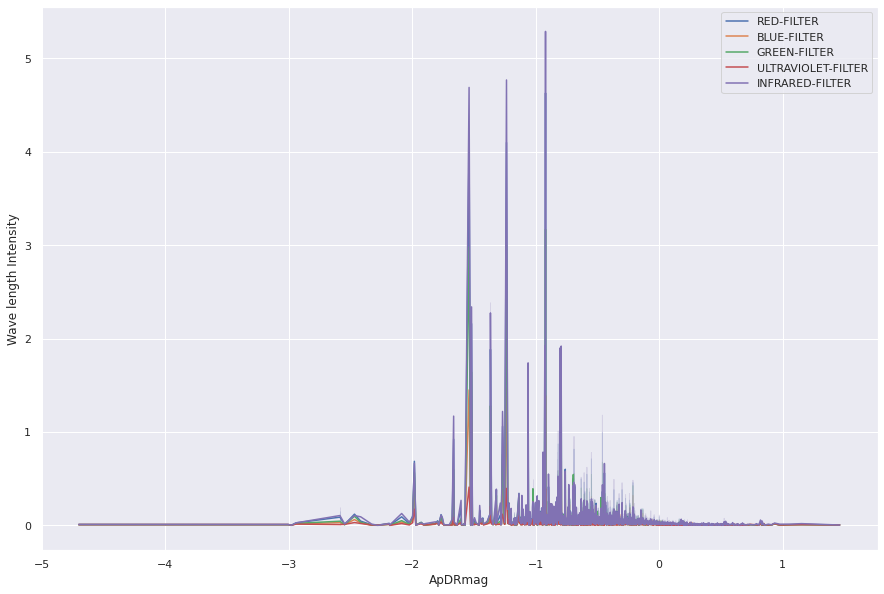

In [24]:
plot_lenwave(column_name='ApDRmag')

Now its clear that the galaxies near to us are the ones with most intense emission.  

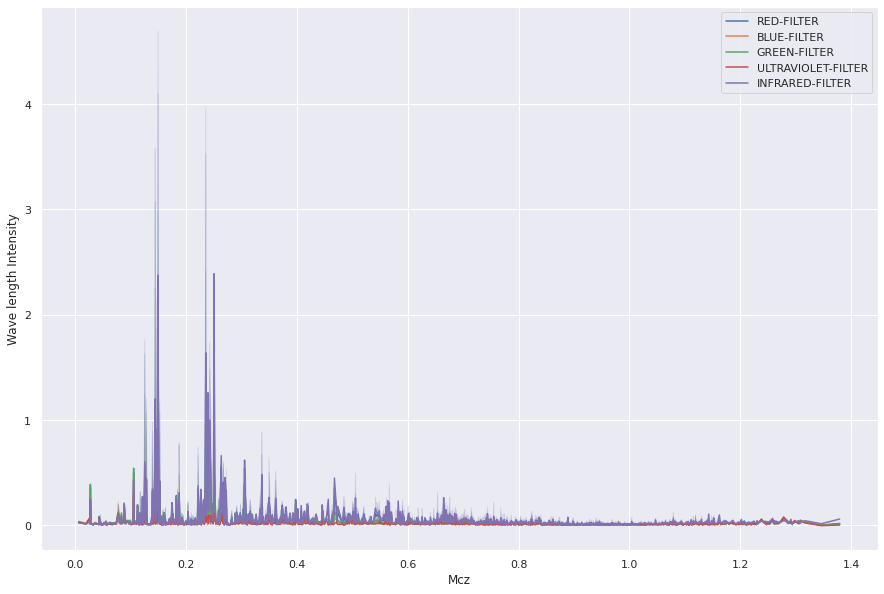

In [25]:
plot_lenwave(column_name='Mcz')

###What do we get from these plots?

- So, based in this plots we can already now that we have a clear tendency to have more bright and median size galaxies near from us. And as long you keep going more and more away from our galaxy you will find less bright galaxies and also bigger.

###Creating a new feature:

- when you are studing astronomy its preatty comon that you have to understand what is a color index. A color index is the measurement of how much ligth he galaxy provides in an especifc range in the eletromagnetic spectrum. That's why to know the color index of any object we have to subtract the magnitude of an object in an especifc magnitude in the eletromagnetic spectrum from the magnitude in another point of the eletroc=magnetic spectrum.

- The most common color index that we have is the BV-index, but the UB-index its also used a lot.

In [26]:
#creating columns for color-index
combo['BV_color_index'] = combo.Bluemag - combo.Opticmag
combo['UB_color_index'] = combo.UVmag - combo.Bluemag

In [27]:
combo.head(1)

,Nr,Rmag,ApDRmag,mumax,Mcz,MCzml,chi2red,UVmag,Bluemag,Opticmag,usMAG,gsMAG,rsMAG,UbMAG,BbMAG,VnMAG,S280MAG,lenwave1,lenwave2,lenwave3,lenwave4,lenwave5,lenwave6,lenwave7,lenwave8,lenwave9,lenwave10,lenwave11,lenwave12,lenwave13,UFS,BLUEfilter,OPTICfilter,REDfilter,InfraREdfilter,BV_color_index,UB_color_index
0,6,24.995,0.935,24.214,0.832,1.4,0.64,-17.67,-17.54,-17.76,-17.83,-17.6,-17.97,-17.76,-17.53,-17.76,-18.22,0.00066,0.0127,0.0189,0.0182,0.0147,0.0166,0.0188,0.0246,0.0245,0.0216,0.0244,0.0377,0.0117,0.0187,0.0163,0.0173,0.0165,0.0247,0.22,-0.13


In this point we have reached one of the most amazing parts of the data visualization with astronomy. Ploting the Distance of the galaxies from us, and the UB-color_index, the espectrum between the Ultra violet and the Optic Blue we can find a really interesting patter. Each point is a galaxy, relaed to the distance and the UB-color_index. And as long you go by the x-axis (the distance) you can find clear vertical bands of points. Those band are cluster os galaxies! Together in the same point of space they share the same distance, because due to the gravitacional force they are grouped together and start to form groups and clsuter, just like our Local Group and the Virgo Supercluster. And we can clearly see the results of those incredible gravitation force IN FRONT OF OUOR EYES. If thats not beautiful i don't know what else is.

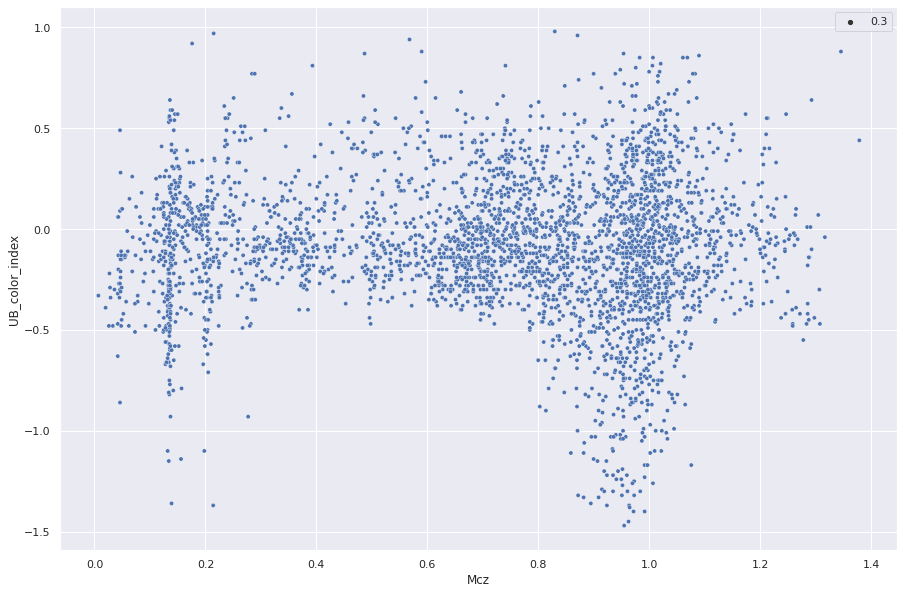

In [28]:
#to be able to find this plot we need to cut some outliers that can make some noise nad create trouble
#thats why we use .loc 
plt.figure(figsize=(15,10))
sns.scatterplot(x=combo.Mcz.loc[(combo.UB_color_index>-1.5)&(combo.UB_color_index<1)], y=combo.UB_color_index, size=0.3)

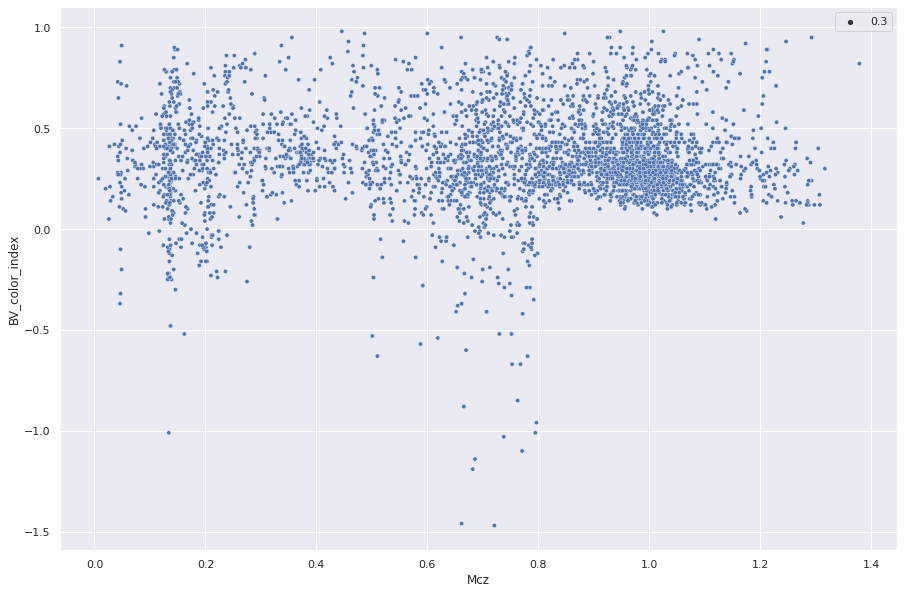

In [29]:
#we can find the same result here with another color index.
plt.figure(figsize=(15,10))
sns.scatterplot(x=combo.Mcz.loc[(combo.BV_color_index>-1.5)&(combo.BV_color_index<1)], y=combo.BV_color_index, size=0.3)

#Cluster Analysis

Know, let's ay we want to group all our galaxies into groups, analyse if there is a pattern going on here. But we want to do that with some relevant features for the galaxies, thing taht metter the most. For a galaxy clusterization i choosed three main features: 

- The DISTANCE of the galaxy from us (MCZ feature correspond to it, its the RedShift of the galaxy. The greater the RedShift the Greater the distance)

- The MAGNITUDE IN RED of the galaxy (Rmag feature. The greater the magnitude more red a galaxy is, and by consequence less bright it is. Low magnitude usually means blue and brighter colors, and bigmagnitudes means red and less bright galaxies)

- The SIZE of the galaxy (ApDRmag is due to this. This is relative to the total and apperent magnitude of the galaxy)

In [30]:
#separeting this features 
combo_cluster = combo.iloc[:,[1,2,4]]

##Dealing with outliers:

Here we have some specificities of our dataset. Galaxies have a huge distributions of colors, shapes, and distances. To be able to do our cluster and also have a representative of the variance in the characteristics of those galaxies we will cut only the EXTREMY outliers, and the ones who will make some trouble to us in the future. (I test tons of possibilities of cuts for those outliers, the best trade of that i founded are seted bellow.)

Disclaimer: usually cut outliers helps a lot distance based algorithms, just like K-means, for example, but that's not an absolute true. usually you have to try a lot of possibilities and find the best fit to your data specifities.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


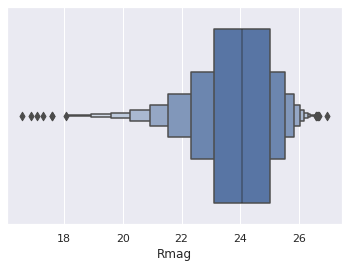

In [31]:
#boxplot to visualize the Magnitude of our galaxies
#they are great to look for outliers
sns.boxenplot(combo_cluster.Rmag)

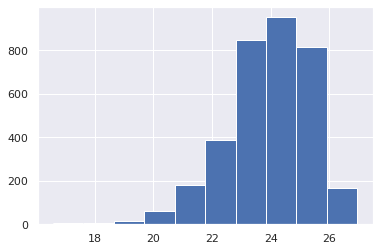

In [32]:
#histogramm of the same data above
#it allows us for look to outliers and have some notion of the sahpe of our data
#a right-skewed shape in this case
combo_cluster.Rmag.hist()

In [33]:
#let's cut the some bad outliers here
combo_cluster = combo_cluster.loc[combo_cluster['Rmag'] >18]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


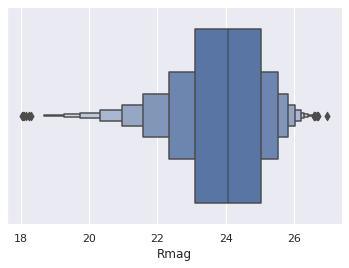

In [34]:
#boxplot for Maganitude after the cut 
#it seems better, and didin't affected to much the galaxies characteristics
sns.boxenplot(combo_cluster.Rmag)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


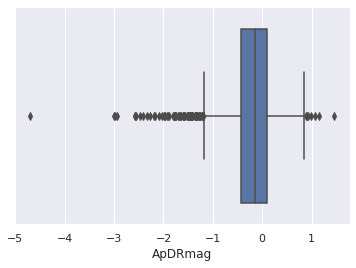

In [35]:
#boxplot for galaxy Size
#here we have some really bad outliers, we need to be a little more agressive with them this time
sns.boxplot(combo_cluster.ApDRmag)

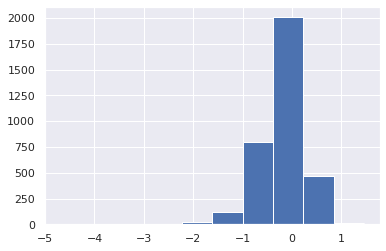

In [36]:
#histogram from the same data abpve
combo_cluster.ApDRmag.hist()

In [37]:
#cuting the outliers, but still alows to small and giant galaxies appers in the dataset
combo_cluster = combo_cluster.loc[combo_cluster['ApDRmag'] >-2]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


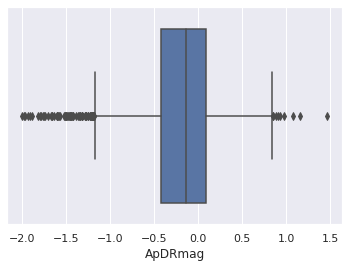

In [38]:
#boxplot of the size after the cut
sns.boxplot(combo_cluster.ApDRmag)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


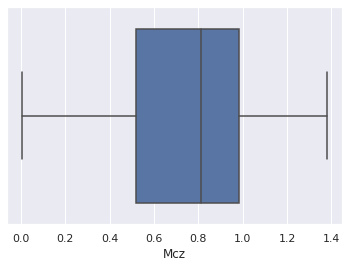

In [39]:
#the distnce of the galaxies from us do not have some baroutliers
sns.boxplot(combo_cluster.Mcz)

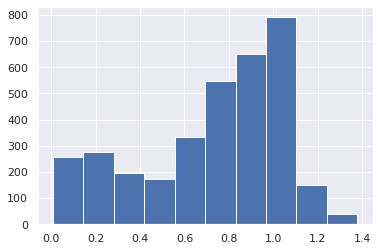

In [40]:
#histogram representing a bimodal data (if you want to see this better, increase the number of the bins) 
combo_cluster.Mcz.hist()

In [41]:
#after some search i founded a good point to discart the mot distant galaxies.
combo_cluster = combo_cluster.loc[combo_cluster['Mcz']<1.2]

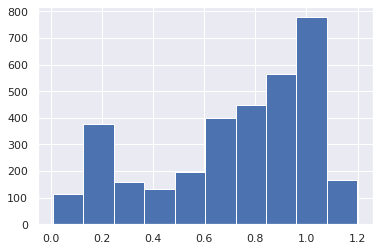

In [42]:
combo_cluster['Mcz'].hist()

In [43]:
#taking a look in outr data right now
combo_cluster.head()

,Rmag,ApDRmag,Mcz
0,24.995,0.935,0.832
1,25.013,-0.135,0.927
3,25.203,0.639,0.912
4,25.504,-1.588,0.848
5,23.740,-1.636,0.882


In [44]:
#there is no missing that here, but jjust for safety:
combo_cluster = combo_cluster.dropna()

## The Algorithms

Here we going to create three different versions of our dataset. One will be the pure dataset, and the other twos will pass for some normalization. Usually the normalization the algorithms based in distances between the poits because it set the same "weigth" to the features. It do not allow tat features with huge scales (maginitude -Rmag- for example, who goes from 18 to 26) affect the model much more than features with tiny scales (just like Mcz, each goes from 0 to 1.2)

### Scaling the Dataset

In [45]:
scaler = StandardScaler()
min = MinMaxScaler()
combo_cluster_scaler = scaler.fit_transform(combo_cluster)
combo_cluster_min = min.fit_transform(combo_cluster)
combo_cluster_scaler

array([[ 0.73898373,  2.64812207,  0.36829732],
       [ 0.75179474,  0.10201997,  0.67256828],
       [ 0.88702215,  1.94377981,  0.6245255 ],
       ...,
       [-0.18198606, -0.61659951,  0.18573474],
       [-0.34425894, -2.22754449,  0.66936543],
       [ 1.18452243, -0.10975862,  0.80388522]])

Now we are going to start our clusterization. We'll test three main algorithms: K-MEANS, AGGLOMERTAIVE CLUSTERING and DBSCAN.

###AGGLOMERATIVE CLUSTERING: 

A clustering based in the idea of starts a cluster with just one point, and from this point, start the aggregation of this points, creating a dendogram based in the distance from each point. The idea is creat small cluster that starts to agregate and create big clusters.

- The distance between the points can be calculated based in the minimun distance possible etween the clusters, the maxium, the average and so on. here we are going to try soome of them with he euclidean distance.

- Our metric for cluster anlysis will be the Silhouette score. The silhouette score measures the average distance between the intra-cluster points and the inter-clusters. Small intra-cluster distance are btter, the points inside the cluster have good cohesion, and big inter-cluster distance are very good, because it means that the clusters are very far fom each other and have a good delimitation. In the Silhouette score greater is better.

In [46]:
def agglomerative_cluster(dataset):
  silhouette_coefficient = []   #list to silhouette score
  for linkage in ['ward', 'complete', 'average', 'single']:   # the distance measuremtn will be based in
    for number in range(2,11):
      agglomerative = AgglomerativeClustering(n_clusters= number, affinity='euclidean', linkage = linkage) #agglomerative model
      agglomerative.fit(dataset)    #fitting the model
      score = silhouette_score(dataset, agglomerative.labels_)
      silhouette_coefficient.append(score)

  #as the list is not separed by the linkage type, we can slice the list into peaces that we know 
  #that represent each type of linkage. take the linkage that generate the best silhouette score to analyse it.    
  print(f'ward: {max(silhouette_coefficient[:9])}, {len(silhouette_coefficient[:9])}')
  print(f'maximun: {max(silhouette_coefficient[9:18])}, {len(silhouette_coefficient[9:18])}')
  print(f'average: {max(silhouette_coefficient[18:27])}, {len(silhouette_coefficient[18:27])}')
  print(f'minimun: {max(silhouette_coefficient[27:36])}, {len(silhouette_coefficient[27:36])}')

agglomerative_cluster(dataset=combo_cluster)

ward: 0.4942452784178788, 9
maximun: 0.49051723656416446, 9
average: 0.522449045892142, 9
minimun: 0.44352108009805213, 9


In [47]:
agglomerative_cluster(dataset=combo_cluster_min)

ward: 0.48896737974158855, 9
maximun: 0.4585067035313014, 9
average: 0.49622027862009327, 9
minimun: 0.47098249200195363, 9


In [48]:
agglomerative_cluster(dataset=combo_cluster_scaler)

ward: 0.3735993686686337, 9
maximun: 0.3811570340108501, 9
average: 0.6128508637328098, 9
minimun: 0.54872861097975, 9


The Agglomertaive cluster sets a random point to starts the cluster, That results in different cluster each times you run the algorithm. So the silhouette score will not be the same when yu run it. But here our best score is around 0.61 (best value possible is 1, the worst is 0)

In [49]:
silhouette_coefficient = []
for linkage in ['ward', 'complete', 'average', 'single']:
  for number in range(2,11):
    agglomerative = AgglomerativeClustering(n_clusters= number, affinity='euclidean', linkage = linkage)
    agglomerative.fit(combo_cluster_scaler)
    score = silhouette_score(combo_cluster_scaler, agglomerative.labels_)
    silhouette_coefficient.append(score)
      
print(f'ward: {max(silhouette_coefficient[:9])}, length: {len(silhouette_coefficient[:9])}')
print(f'maximun: {max(silhouette_coefficient[9:18])}, length: {len(silhouette_coefficient[9:18])}')
print(f'average: {max(silhouette_coefficient[18:27])}, length: {len(silhouette_coefficient[18:27])}')
print(f'minimun: {max(silhouette_coefficient[27:36])}, length: {len(silhouette_coefficient[27:36])}')

ward: 0.3735993686686337, length: 9
maximun: 0.3811570340108501, length: 9
average: 0.6128508637328098, length: 9
minimun: 0.54872861097975, length: 9


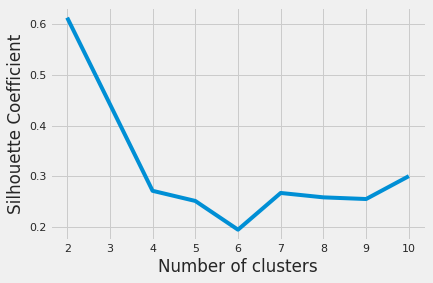

In [50]:
#Let's plot the silhouette coefficient by number of clusters for the best linkage
plt.style.use('fivethirtyeight')
plt.plot(range(2,11), silhouette_coefficient[18:27])
plt.xticks(range(2,11))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

Here we can see one of the prolems that we must deal in this case. Our best agglomerative clustering is good beacuse in creates a cluster who involves almost all the points in the dataset, being just a few points out of that cluster. This means that our cluster its not relevant for our analysis. You can see it graphically in the dendogram bellow. Just one color means there is just one cluster.

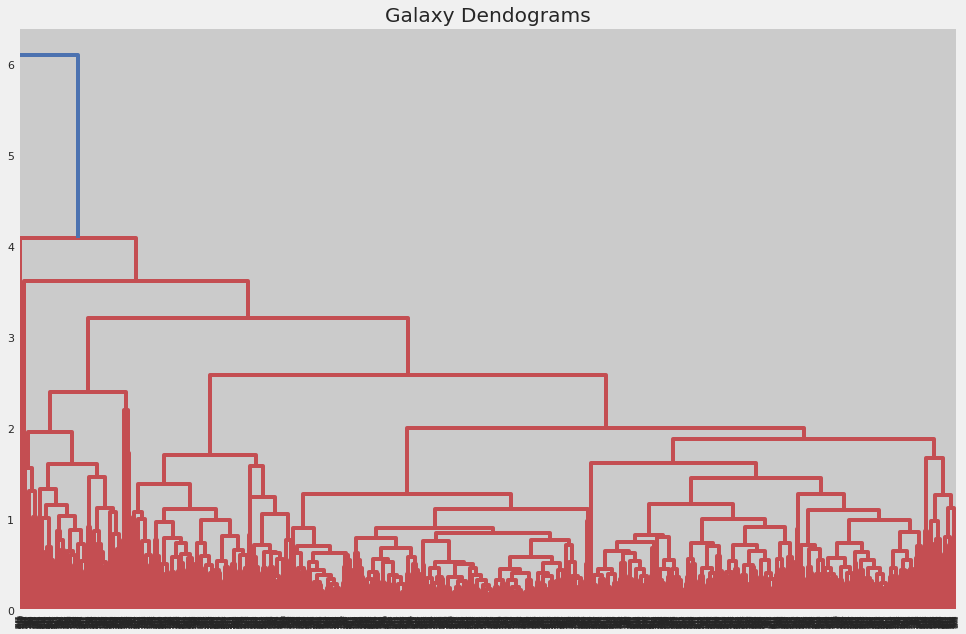

In [51]:
plt.figure(figsize=(15, 10))
plt.title('Galaxy Dendograms')
dend = shc.dendrogram(shc.linkage(combo_cluster_scaler, method='average'))

###K-MEANS:

In the K-mEANS algorithm you MUST chose the number of clusters that you want to set. This number will create the same nuber of centroids. This centroids will be used as the center of the cluster. In each iteration of the algorithm the centroid will migrate to the best possible place, where the average of the distance of this centroid to the nerest points are the smallest as possible. 

- Thats why we need to set a Number of iterations, in this case: 500
- need to set a number of the cluster (centroids) to be created
- the init parameter can be used as 'random', so the centroids will be seted randomly is the n-dimensional space (here: 3D space). But when you set the k-means++ parametrs the centroids will be seted with some distance between those centroids, helping the algorithm to converge. 

In [52]:
# as before, try different combinations of cluster hyperparameters, and saving the sum of square error 
def sse_kmeans_cluster(dataset):
  sse = []
  for k in range(1,11):
    kmeans = KMeans(n_clusters = k, init='k-means++', n_init=50, max_iter=500, random_state=42 )
    kmeans.fit(dataset)
    sse.append(kmeans.inertia_)
  print(sse)
  return sse
sse = sse_kmeans_cluster(dataset=combo_cluster)

[7506.846403705301, 3019.0830793445434, 1772.5662417060846, 1283.8487935841824, 1052.2648369975336, 908.5552546224585, 809.5316217158064, 734.7658472071635, 675.2231325903472, 623.2686633130421]


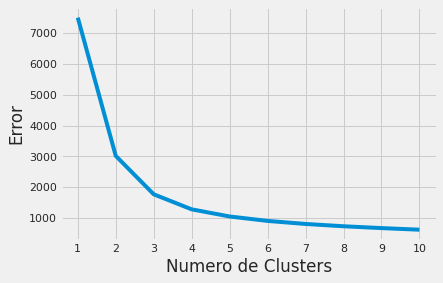

In [53]:
# here we plot the sum of square error that each combination of clusters
#as we can see, around the two and 3 cluster we have a good trade of between low error and a goos number of clusters
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel('Numero de Clusters')
plt.ylabel('Error')
plt.show()

Here we are going to use a k new method: the elbow method. Using the derivative of the function, and where it have the greatest value will be you elbow, be best trade of for you.

In [54]:
knee = KneeLocator(
    range(1,11), sse, curve = 'convex', direction = 'decreasing'
)
print(f'The flexure points: {knee.elbow}')

The flexure points: 3


In [55]:
#now using the silhouette coefficient
#first with the combo_cluster dataset
def silhouette_kmeans_cluster(dataset):
  silhouette_coefficient = []
  for k in range(2,11):
    kmeans = KMeans(n_clusters = k, init='k-means++', n_init=30, max_iter=500, random_state=42 )
    kmeans.fit(dataset)
    score = silhouette_score(dataset, kmeans.labels_)
    silhouette_coefficient.append(score)
  return silhouette_coefficient
silhouette_kmeans_cluster(dataset=combo_cluster)

[0.5011055122384386,
 0.4571465129397747,
 0.4002695896166195,
 0.35538015739798523,
 0.33327668630640267,
 0.30791401628230713,
 0.333646764502166,
 0.3080834442865803,
 0.31136586909643066]

In [56]:
# now with combo_cluster_min
silhouette_kmeans_cluster(dataset=combo_cluster_min)

[0.4919418956310113,
 0.3991335663846211,
 0.39065064214479284,
 0.3685273794736458,
 0.351059654400436,
 0.32253725333860284,
 0.30276284841870404,
 0.2960821252030834,
 0.2977580101183044]

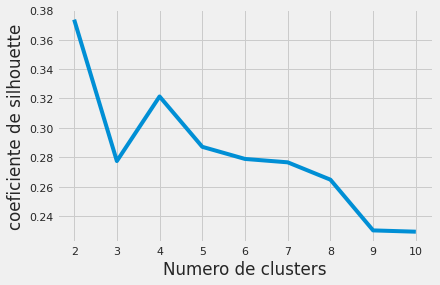

In [57]:
#ploting with combo_cluster_min
#and here we have the ebst k-means possible
plt.style.use('fivethirtyeight')
plt.plot(range(2,11), silhouette_coefficient[:9])
plt.xticks(range(2,11))
plt.xlabel('Numero de clusters')
plt.ylabel('coeficiente de silhouette')
plt.show()

In [58]:
#with combo_cluster_scaler
silhouette_kmeans_cluster(dataset=combo_cluster_scaler)

[0.38094797381046447,
 0.39386210370572117,
 0.3670358503653229,
 0.3175294848624851,
 0.3200322087319298,
 0.30816418485299685,
 0.2960893224927249,
 0.29805377117988896,
 0.2979147556739082]

###DBSCAN:

The Density Based Spacial Clustering for Application with Noise) we have a different approach, Here we need three types of points:

- Core points: this points will be used as "centers" for N other points (choosen by you) inside a specific radius, where all the other points around will be used as border points

- Border points: this points is every single point wich do not have N points around them, like the core points

- Outlier is a point wich are not reachable for core points , and not a border point

This means, it uses distance, but also deal with non spherical clusters, and with random shapes. And maybe it will be usefull for our problem.

In [59]:
def dbscan_cluster(dataset):
  silhouette_coefficient=[]
  #setting radius for core points
  for radius in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #setting number of points inside the radius
    for n_samples in [2,3,4,5,6,7,8,9,10]:
      dbscan = DBSCAN(eps=radius,min_samples = n_samples)
      dbscan.fit(dataset)
      score = silhouette_score(dataset, dbscan.labels_)
      silhouette_coefficient.append(score)
      
  print(f'radius-0.1: {max(silhouette_coefficient[:9])}, {len(silhouette_coefficient[:9])}')
  print(f'radius-0.2: {max(silhouette_coefficient[9:18])}, {len(silhouette_coefficient[9:18])}')
  print(f'radius-0.3: {max(silhouette_coefficient[18:27])}, {len(silhouette_coefficient[18:27])}')
  print(f'radius-0.4: {max(silhouette_coefficient[27:36])}, {len(silhouette_coefficient[27:36])}')
  print(f'radius-0.5: {max(silhouette_coefficient[36:45])}, {len(silhouette_coefficient[36:45])}')
  print(f'radius-0.6: {max(silhouette_coefficient[45:54])}, {len(silhouette_coefficient[45:54])}')
  print(f'radius-0.7: {max(silhouette_coefficient[54:63])}, {len(silhouette_coefficient[54:63])}')
  print(f'radius-0.8: {max(silhouette_coefficient[63:72])}, {len(silhouette_coefficient[63:72])}')
  print(f'radius-0.9: {max(silhouette_coefficient[72:81])}, {len(silhouette_coefficient[72:81])}')


In [60]:
# using combo_cluster
dbscan_cluster(dataset=combo_cluster)

radius-0.1: -0.4143371989081663, 9
radius-0.2: 0.39891137246011804, 9
radius-0.3: 0.4326813783069336, 9
radius-0.4: 0.47660951519889494, 9
radius-0.5: 0.5238850242311964, 9
radius-0.6: 0.6147466907825663, 9
radius-0.7: 0.6651034645975454, 9
radius-0.8: 0.6629583474571044, 9
radius-0.9: 0.44352108009805213, 9


In [61]:
#the combo_cluster_min creates an unique cluster, thats not usefull for us
#dbscan_cluster(dataset=combo_cluster_min)

In [62]:
#using the combo_cluster_scaler
dbscan_cluster(dataset=combo_cluster_scaler)

radius-0.1: -0.23686084130277302, 9
radius-0.2: -0.2107584319601998, 9
radius-0.3: 0.3243593097897206, 9
radius-0.4: 0.40622695571951456, 9
radius-0.5: 0.45715162238046303, 9
radius-0.6: 0.4689648772588061, 9
radius-0.7: 0.4842002220382189, 9
radius-0.8: 0.5788258042885585, 9
radius-0.9: 0.612748864352446, 9


In [63]:
#using the best dbscan 
dbscan_silhouette_coefficient=[]
for n_samples in [2,3,4,5,6,7,8,9,10]:
  dbscan = DBSCAN(eps=0.7,min_samples = n_samples)
  dbscan.fit(combo_cluster)
  score = silhouette_score(combo_cluster, dbscan.labels_)
  dbscan_silhouette_coefficient.append(score)

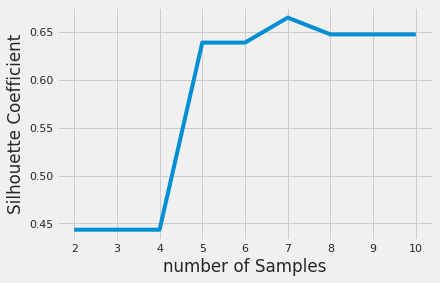

In [64]:
#using radius of 0.7 and searching for number of samples inside this radus, in this case: 7 
plt.style.use('fivethirtyeight')
plt.plot(range(2,11), dbscan_silhouette_coefficient)
plt.xticks(range(2,11))
plt.xlabel('number of Samples')
plt.ylabel('Silhouette Coefficient')
plt.show()

###Best algorithms and hyperparameters

To a better visualization of our tools i will display our bests options for each algorithm, and then we set their classification for each point in the combo-cluster dataset

In [65]:
#train agglomerative cluster with the best hyperparameters
agglomerative_cluster = AgglomerativeClustering(n_clusters = 2, linkage='average', affinity='euclidean')
agglomerative_cluster.fit_predict(combo_cluster_scaler)

#append the labels to every galaxy 
combo_cluster['hierarchical_label'] = agglomerative_cluster.labels_

In [66]:
# train kmeans cluster with the best hyperparameters
kmeans_model = KMeans(n_clusters = 2, init='k-means++', n_init=50, max_iter=500, random_state=42 )
final_kmeans = kmeans_model.fit(combo_cluster_min)
kmeans_label = final_kmeans.labels_

#append the labels to every galaxy
combo_cluster['kmeans_label'] = kmeans_label

In [67]:
#train DBSCAN cluster with the best hyperparameters
dbscan_model = DBSCAN(eps=0.7, min_samples=7)
best_dbscan = dbscan_model.fit(combo_cluster)
dbscan_labels = best_dbscan.labels_

#append label
combo_cluster['dbscan_label'] = dbscan_labels 

In [68]:
# taking a look in the dataset 
combo_cluster.head(3)

,Rmag,ApDRmag,Mcz,hierarchical_label,kmeans_label,dbscan_label
0,24.995,0.935,0.832,0,1,0
1,25.013,-0.135,0.927,0,1,0
3,25.203,0.639,0.912,0,1,0


## Understanding the Results

In [69]:
# here we can see our greatest problem with the agglomertaive cluster
# almost every point were classified as the same cluster, that's not usefull 
# REMEMBER: silhouette_coefficient = 0.57
combo_cluster['hierarchical_label'].value_counts()

0    3337
1       2
Name: hierarchical_label, dtype: int64

In [70]:
#here we hhave a better distribution, with two clusters created
#REMEMBER: silhouette_coefficient = 0.49
combo_cluster['kmeans_label'].value_counts()

1    2183
0    1156
Name: kmeans_label, dtype: int64

In [71]:
# here we have 3 clsuter 9notice: the third cluster (-1) was created based in the extreme values of the label 0 from kmeans 
# REMEMBER: silhouette_coefficient = 0.66 (our best value) 
combo_cluster['dbscan_label'].value_counts()

 0    2183
 1    1150
-1       6
Name: dbscan_label, dtype: int64

### 3D Plots

Now we can see in a 3D plot how the clusters were asign to the galaxies

- Firts when can see that in the AGGLOMERATIVE cluster all the points have the same color (red), that means they are part of the same cluster, there is no difference between them, and we can see  that the points are not equal, or part of the sam estructure. So that won't be usefull for us. 

- That was problably caused by our outliers here, but i still prefer keep these points to be plausible with he reality.

Text(0.5, 0, 'DISTANCIA (Mcz)')

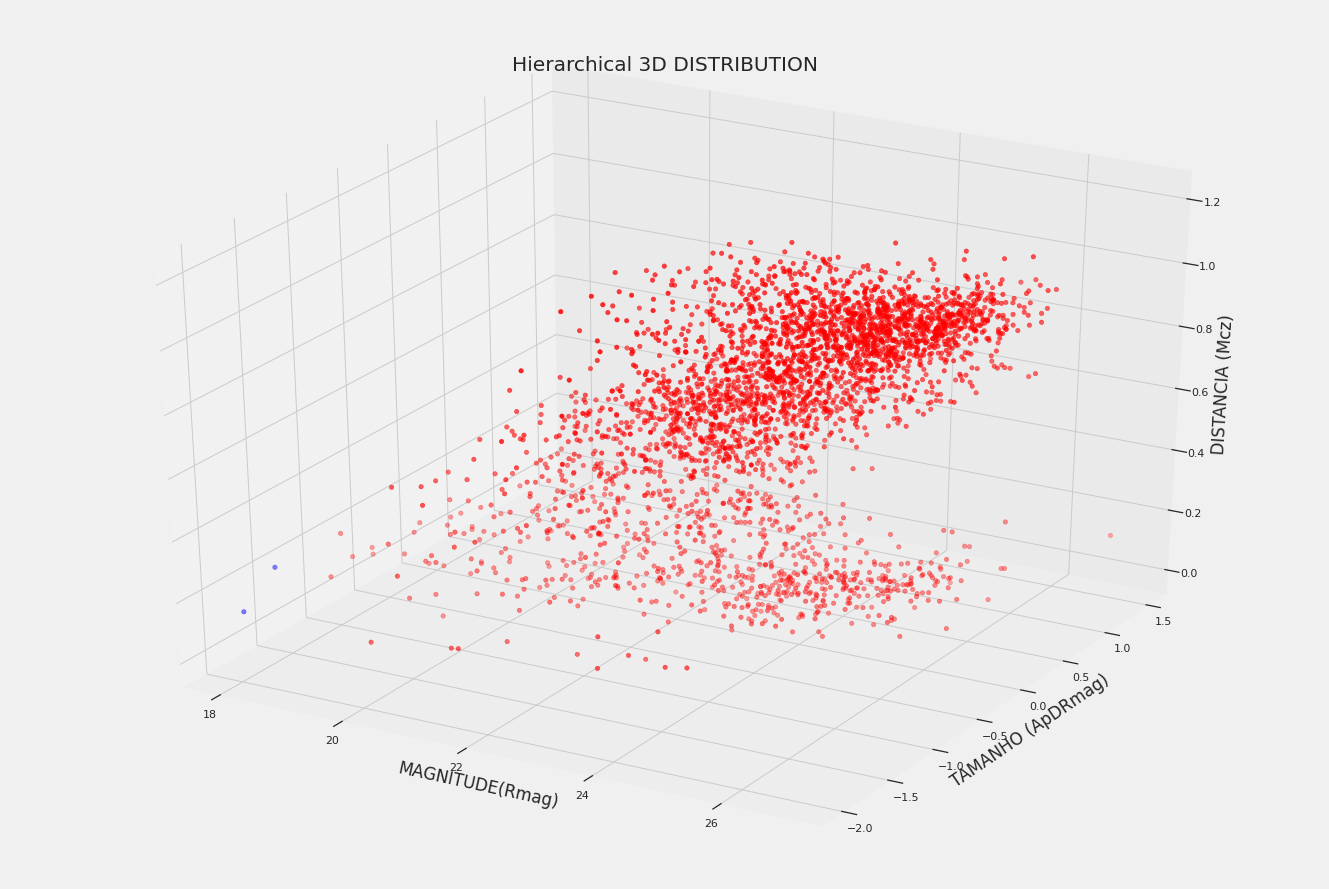

In [72]:
from mpl_toolkits.mplot3d import Axes3D

cores = {0:'red', 1:'blue'}

fig = plt.figure(figsize=(21, 15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(combo_cluster.Rmag, combo_cluster.ApDRmag, combo_cluster.Mcz,
           c= combo_cluster.hierarchical_label.apply(lambda x: cores[x]))
ax.set_title('Hierarchical 3D DISTRIBUTION')
ax.set_xlabel('MAGNITUDE(Rmag)')
ax.set_ylabel('TAMANHO (ApDRmag)')
ax.set_zlabel('DISTANCIA (Mcz)')

Using the K-MEANS to display our points we can see a better clusterization, where we have two groups of galaxies, a little bit overlaped, but far better than the agglomertaive algorithm. That overlaping usually is due to the similarity between some galaxies, that probably happen because some galaxies are in transition from one group to another, or just anomalous galaxies. 

Text(0.5, 0, 'DISTANCIA (Mcz)')

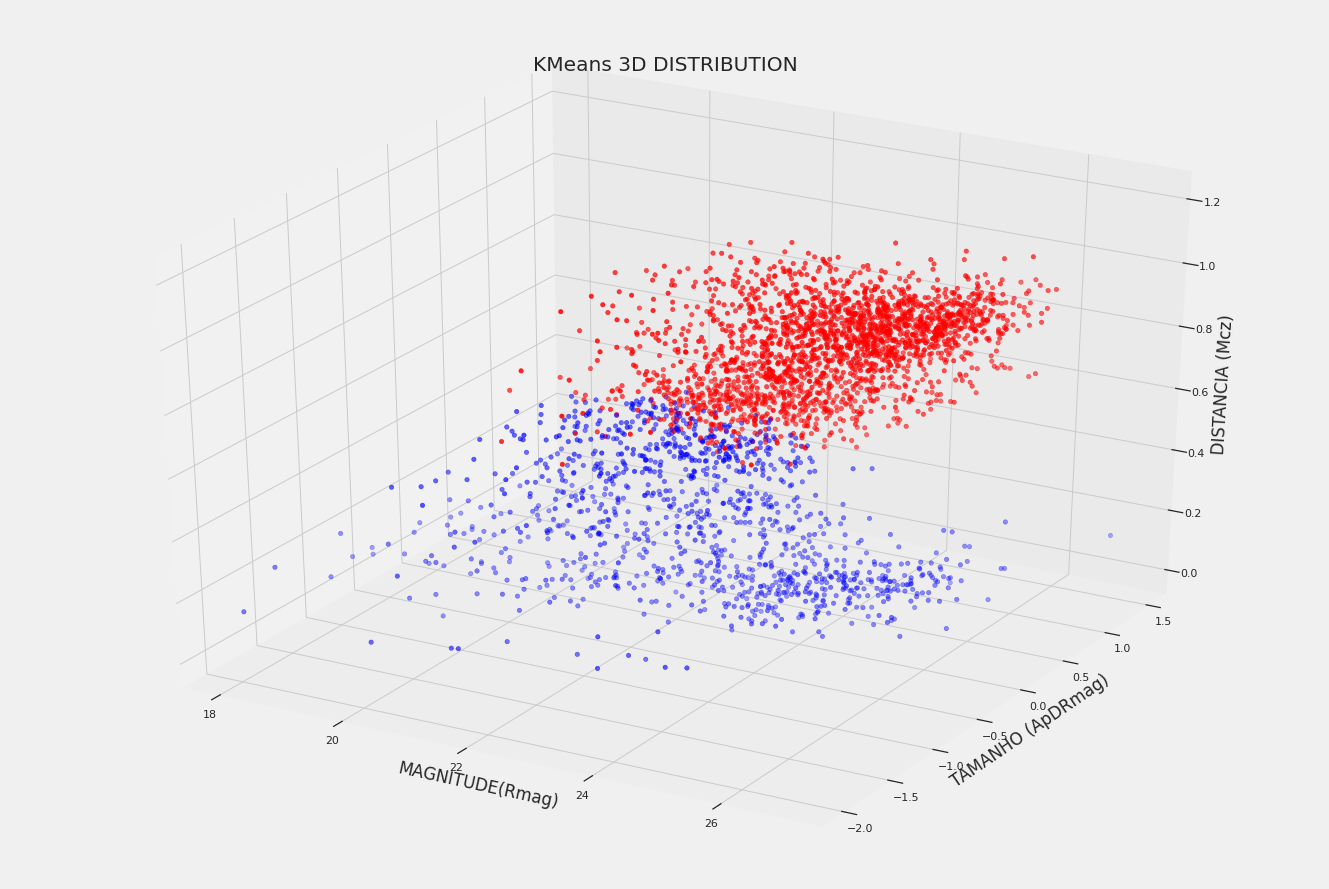

In [73]:
from mpl_toolkits.mplot3d import Axes3D

cores = {1:'red', 0:'blue'}

fig = plt.figure(figsize=(21, 15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(combo_cluster.Rmag, combo_cluster.ApDRmag, combo_cluster.Mcz,
           c= combo_cluster.kmeans_label.apply(lambda x: cores[x]))
ax.set_title('KMeans 3D DISTRIBUTION')
ax.set_xlabel('MAGNITUDE(Rmag)')
ax.set_ylabel('TAMANHO (ApDRmag)')
ax.set_zlabel('DISTANCIA (Mcz)')

Finally we have our DBSCAN classification, and as we can see there are three cluster now, two very similar to the K-means cluster, and one more with some extremy vaues related with the maginitude and the size of the galaxy. One consequence of the good clusterization is that here we have less overlaping than before, that could the know by the better silhouette coeficcient.

Text(0.5, 0, 'DISTANCIA (Mcz)')

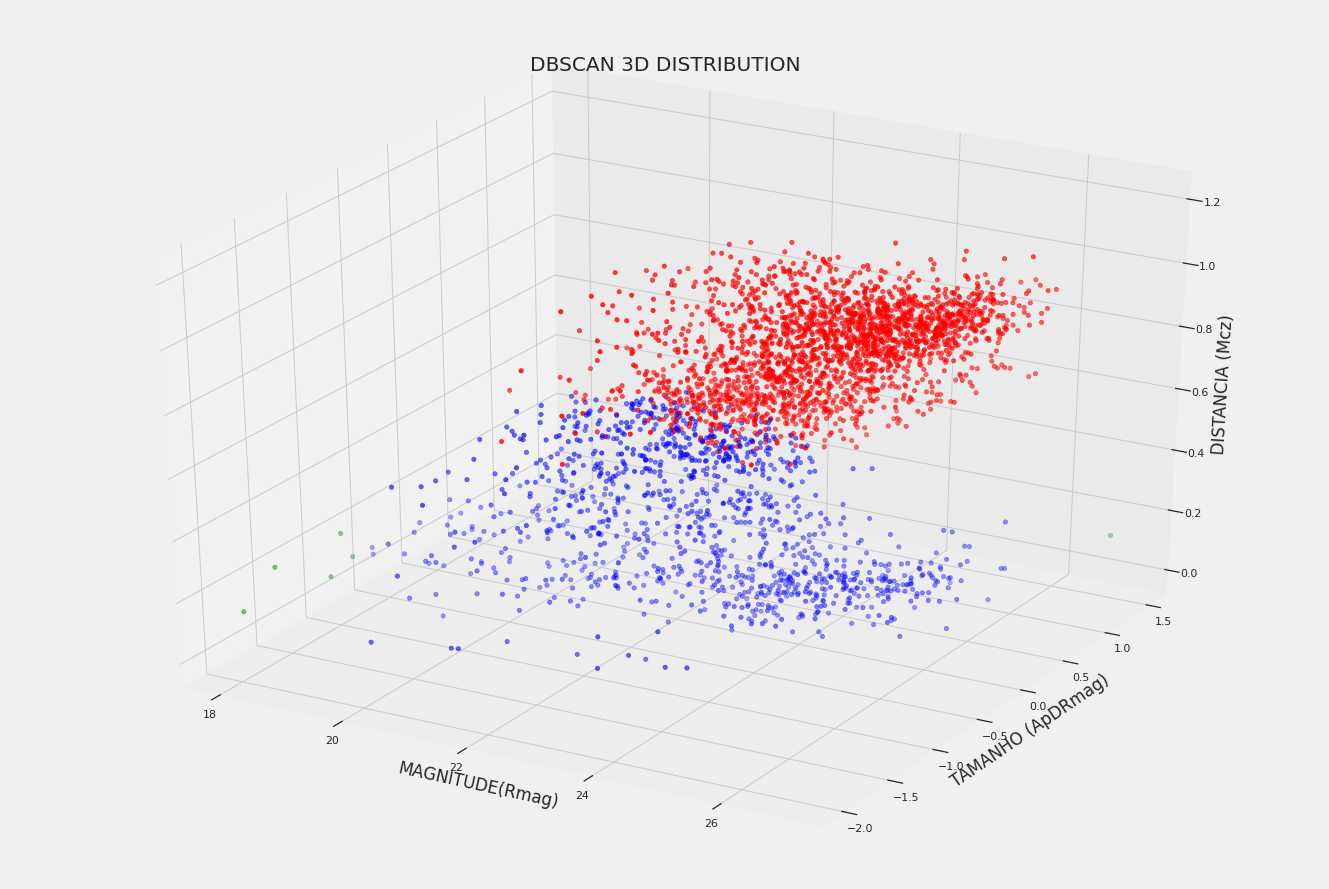

In [74]:
from mpl_toolkits.mplot3d import Axes3D

cores = {0:'red', 1:'blue', -1:'green', 2:'yellow'}

fig = plt.figure(figsize=(21, 15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(combo_cluster.Rmag, combo_cluster.ApDRmag, combo_cluster.Mcz,
           c= combo_cluster.dbscan_label.apply(lambda x: cores[x]))
ax.set_title('DBSCAN 3D DISTRIBUTION')
ax.set_xlabel('MAGNITUDE(Rmag)')
ax.set_ylabel('TAMANHO (ApDRmag)')
ax.set_zlabel('DISTANCIA (Mcz)')

Taking a look by other positions. Lokking by the side of the plot we can see a non spherical cluster, and thats why the DBSCAN got better results than the other algorithms. The blue uster seems to be nearest to the Earth, and in general have lower magnitudes.

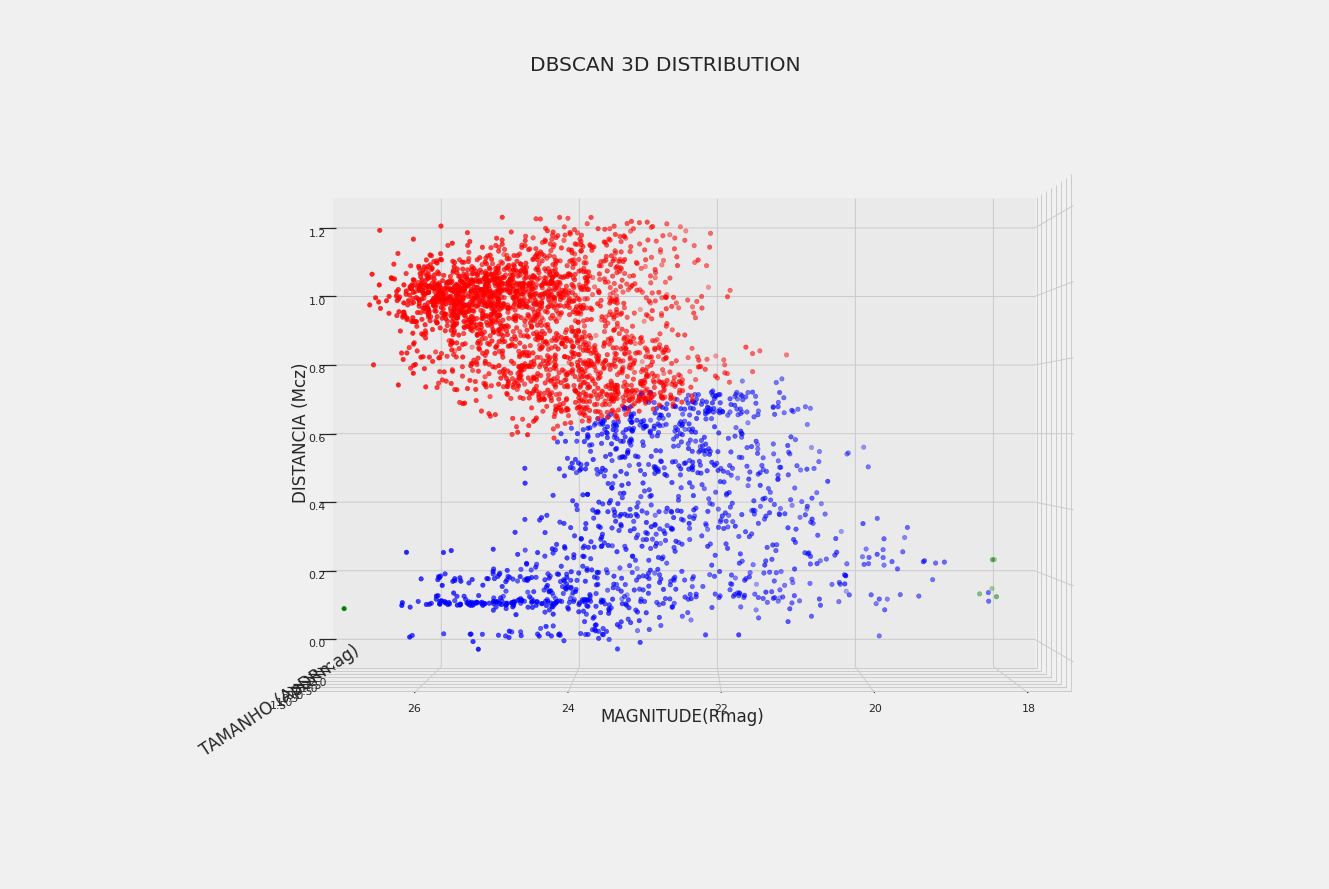

In [75]:
from mpl_toolkits.mplot3d import Axes3D

cores = {0:'red', 1:'blue', -1:'green'}

fig = plt.figure(figsize=(21, 15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(combo_cluster.Rmag, combo_cluster.ApDRmag, combo_cluster.Mcz,
           c= combo_cluster.dbscan_label.apply(lambda x: cores[x]))
ax.set_title('DBSCAN 3D DISTRIBUTION')
ax.set_xlabel('MAGNITUDE(Rmag)')
ax.set_ylabel('TAMANHO (ApDRmag)')
ax.set_zlabel('DISTANCIA (Mcz)')
ax.view_init(0,90)

A view from above shows us the relationship between size and magnitude. The more the size ncreases more red is the galaxy. Thats not a rule, and there is some overlaping there, but still possible to understand that. (Remeber, the greater the magnitude, more red and less brigth the galaxy is (and usually bigger).

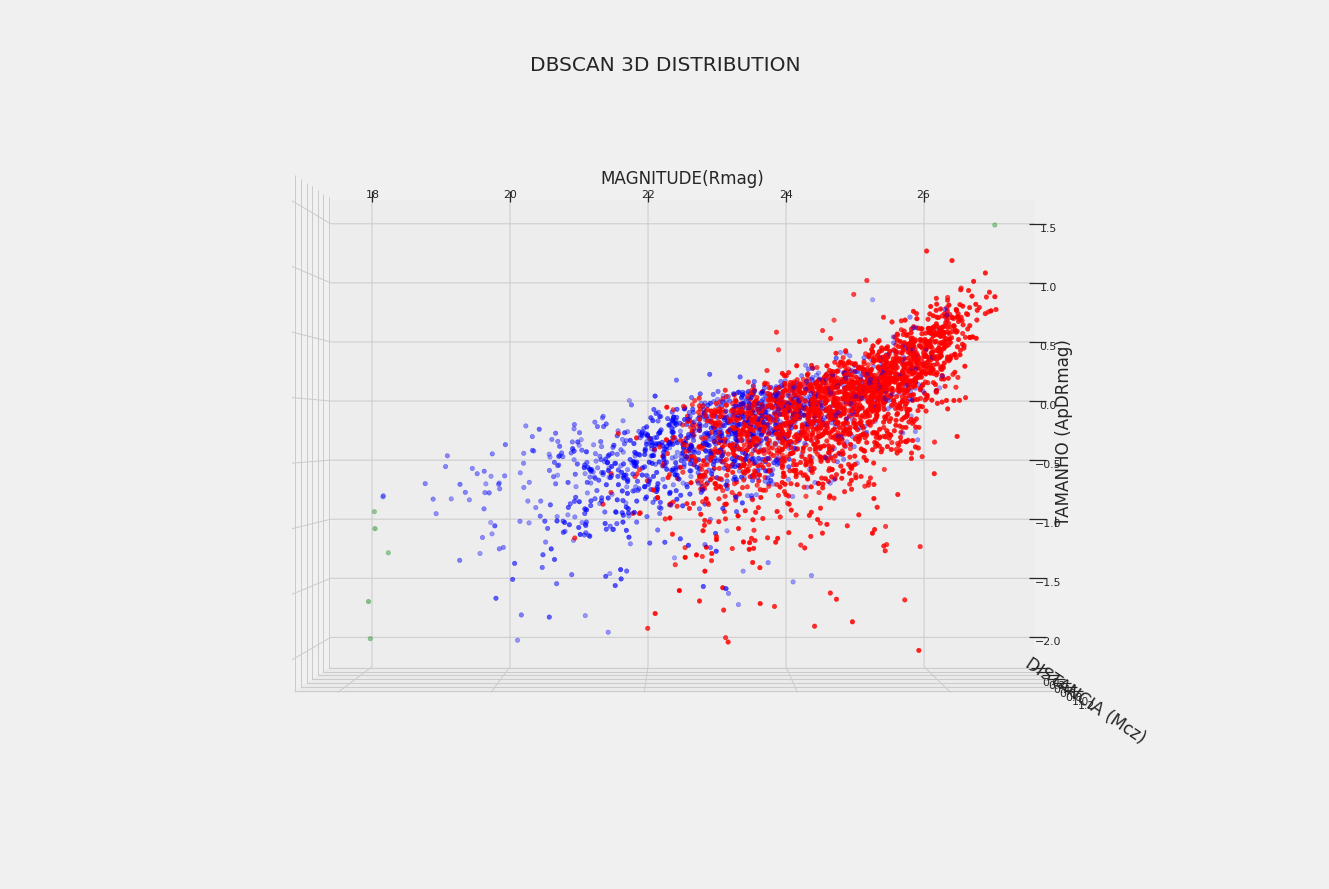

In [76]:
from mpl_toolkits.mplot3d import Axes3D

cores = {0:'red', 1:'blue', -1:'green'}

fig = plt.figure(figsize=(21, 15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(combo_cluster.Rmag, combo_cluster.ApDRmag, combo_cluster.Mcz,
           c= combo_cluster.dbscan_label.apply(lambda x: cores[x]))
ax.set_title('DBSCAN 3D DISTRIBUTION')
ax.set_xlabel('MAGNITUDE(Rmag)')
ax.set_ylabel('TAMANHO (ApDRmag)')
ax.set_zlabel('DISTANCIA (Mcz)')
ax.view_init(90,270)

## the means of the Cluster

Now we can group by the dataset by the labels that we created with the clustering algorithms, finding the mean of each feature and knowing the average value of each feature that we want.

In [77]:
combo_cluster.groupby('kmeans_label').mean()

,Rmag,ApDRmag,Mcz,hierarchical_label,dbscan_label
kmeans_label,,,,,
0,22.934899,-0.350656,0.346676,0.00173,0.989619
1,24.497788,-0.086378,0.913119,0.00000,0.000000


In [78]:
combo_cluster.groupby('dbscan_label').mean()

,Rmag,ApDRmag,Mcz,hierarchical_label,kmeans_label
dbscan_label,,,,,
-1,19.603333,-0.906500,0.175500,0.333333,0
0,24.497788,-0.086378,0.913119,0.000000,1
1,22.952281,-0.347756,0.347569,0.000000,0


# Statistical Analysis

As we can se, the DBSCAN algorithm did a better job than the other ones. In fact it did a silhouette score of 0.64. Not a bad score. This algorithm returned three cluster. Where greater Rmag means more red galaxies,  more positive ApDRmag means bigger galaxies and higher Mcz is related to far galaxies, and here is their analysis:
  

- Label 0: Here we have a clear Red Giant galaxies. Those kind os struture usualy are bigger tahn the other, because they were formed by the merge of other galaxies, like two blue galaxies or small red galaxies.

- Label 1: A variety of blues galaxies. There are two types of galaxies, barred spiral galaxies and non-barred spiral galaxies. We can't tell with those data what kind each galaxy is, but with The Magnitude in Red (Rmag) we can clearly say that are Blue median size galaxies in avarege.

- Label -1:There just a few samples of that type here, so its hard to be sure os what we're seeing. but it seems to be a very intense and dwarf blue galaxies. With a very low Rmag and small size comparing with the two other samples.

##EVALUATING SIZE

###Hypothesis Test with Two sample T-test

With those datas into our hands we can start to try to figure some queestions that could come to your mind. A good thought is: That difference in size between these two samples are true ? Can we say these two populations are really different by size? 

To to that we can just to a simple Two Samples T-test. In that case we can treat this the groups of galaxies (Label 0 and label 1) as two samples of all the galaxies that we could have. Label 0 will be called as the Red population and Label 1 will be called as Blue population. So, with these the samples in our hands we are capable to look for the difference in the mean size of these two groups of galaxies. To do that we're going to create a Hypotesis Test, wich is a test to validate if two groups are similar enough or not. So we create a Null Hypothesis, wich is the idea of the mean size of these two samples are  similar enough to considere then as part of the same population galaxies size. An we create an Alternative Hypothesis, that tells us teh mean sie os those groups are so different that we could teel the are part of two distinquisy populations. O let's put our hand on the hypothesis test:

- Hypothesis Tes
  - H0: mean size Red sample = mean size Blue sample
  - H1: mean size Red sample != mean size Blue sample

- Alpha level:
  -  0.05: this number set an acceptable level of certainty that we need to have to retain or reject the null hypothesis. This means we need to have less than 5% of probability to take a t-test result by chance and not due to a true characteristics of the mean



###EVALUATING THE NORMALITY OF OUR DATA: ( we have three aprouches

  - Histogram: the easier and less acurated way to analyse a distribution. Its a good start but ever the point of a last decision.

  - QQplot: acording to some discutions s the most acurated way to vizualize the normalite of the data, especialy for tons of data, just like our case. here we plot all the points of our distributions against the expected quartils of a normal distribution. If your point follow the normal line of those quartil you can considere your data as a normal or like-normal curve.

  - Normality test (Shapiro Wilk test): a good statistical test, where H0 is the hypothesis of normality of your data and H1 is the non-normality of the data. If p > 0.05 you have a normal curve, else, your curve is not normal. Acording to my researchs this test is affected for just a few differences in your data from the normal curve when your dataset is hugh. So we'll be not using those test as a last word for normality. 

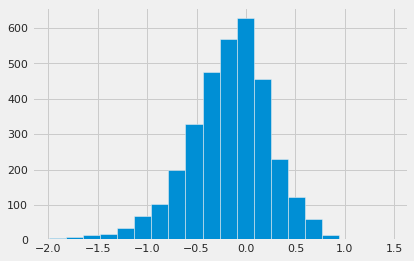

In [79]:
#taking a look in all ApDRmag points
#it looks like normal, but with ligth right-skewed data
combo_cluster['ApDRmag'].hist(bins=20)

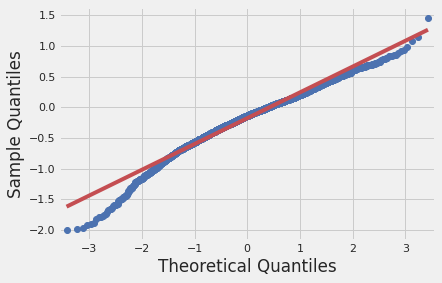

In [80]:
qqplot(combo_cluster['ApDRmag'], line='s')
plt.show()

In [81]:
#as we can se, despite of the normal like curve, 
#the shapiro wilk test tells us our data is really far from the normality [p(0.05)>>>>>0.2085440954504141e-21]
stats, p = shapiro(combo_cluster['ApDRmag'])
print(stats, p)

0.9793535470962524 1.2085440954504141e-21


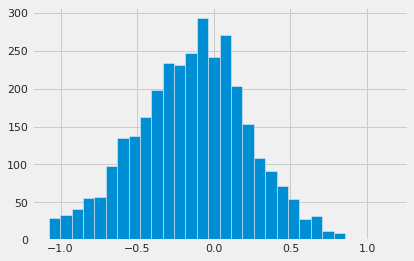

In [82]:
#here we'll cut some outliers, mainly the smallest values, that is due to Label -1 (dwarf galaxies), so we can cut them
size = combo_cluster['ApDRmag'].loc[(combo_cluster['ApDRmag'] >-1.08)&(combo_cluster['ApDRmag']<1.3)] 
size.hist(bins = 30)


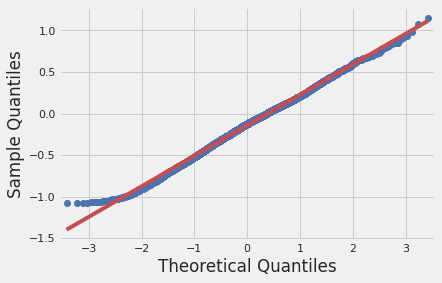

In [83]:
#here we can clearly see that the data is much more normal-like data
qqplot(size, line='s')
plt.show()

In [84]:
stats, p = shapiro(size)
print(f'{stats}, {p:.10f}')

0.9973203539848328, 0.0000189148


Now we can considure our data as a normal like data. So lets start to separete our data and see how their distribution looks like.

Firts of all we need to separate our data in two groups. One group will cointain the size of Label 0 group, wich we're going to call "red_sample", and the other will contain the size from Label 1 group, the "blue_sample. 

In [85]:
red_sample = combo_cluster['ApDRmag'].loc[(combo_cluster['ApDRmag'] >-1.08)&(combo_cluster['ApDRmag']<1.3)&(combo_cluster['dbscan_label']==0)]
blue_sample = combo_cluster['ApDRmag'].loc[(combo_cluster['ApDRmag'] >-1.08)&(combo_cluster['ApDRmag']<1.3)&(combo_cluster['dbscan_label']==1)]

RED SAMPLE

Does the red sample follow the normality?

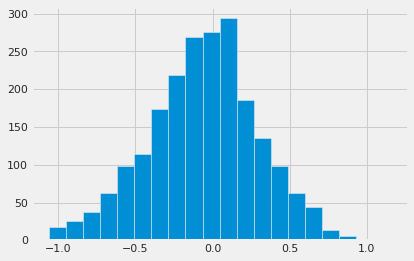

In [86]:
red_sample.hist(bins=20)

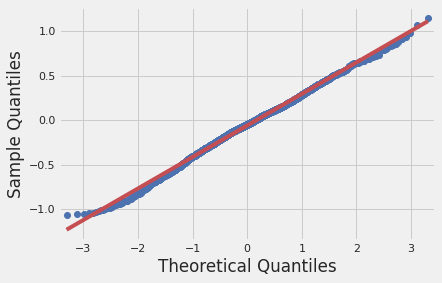

In [87]:
qqplot(red_sample, line='s')
plt.show()

BLUE SAMPLE

Does blue_sample follow the normality?

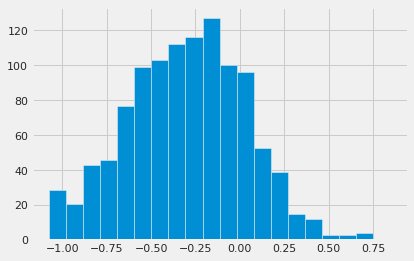

In [88]:
blue_sample.hist(bins=20)

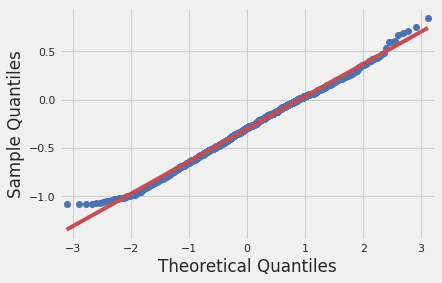

In [89]:
qqplot(blue_sample, line='s')
plt.show()

###The T-test

Now we are able to start our TWO SAMPLE T-TEST for INDEPENDENT SAMPLES

To be able to do this test you need to know how far the the means are from each other in standard deviation units. To find that you can use the formula:
  - t-statistc = difference of the sample means /standard error of the difference between the means
  - and the standard error of the differences between the means is:
    - The square of standard error from the first sample / number of samples inside of sample 1 +   square of standard error from the second sample / number of samples inside of sample 2

Here we are going to create a step-by-step two sample t-test for independent samples. That's good if you want to understand better how do we get the final result. After that we can compare it with a scipy function that returns a similar function

In [90]:
#let's deffine a function to find the t-statistic
def t_statistic(): 
  #set an alpha value 
  alpha = 0.05
  
  #first lets find the red sample mean and the blue sample mean, then find their differencw
  bsm = blue_sample.mean() #blue sample mean
  rsm = red_sample.mean() #red sample mean
  dsm = rsm - bsm #difference of sample means 

  #now we need to find the square root of the differences between the menas
  #find the standard deviation of the samples. I'll be using Benso's correction fot samples
  std_rs = stdev( red_sample) #for population use pstdev()
  std_bs = stdev(blue_sample)

  #find number of samples in each group
  n_rs = len(red_sample)
  n_bs = len(blue_sample)

  #calculate standard error of the difference between the means
  dbm = sqrt(((std_rs**2)/n_rs) + ((std_bs**2)/n_bs))

  #t-statistic
  t = dsm / dbm 

  # find the degrees of freedom
  df = n_rs+n_bs - 2

  #find the critical value using the  percent point function (ppf)
  crit_val =  scipy.stats.t.ppf(1.0 -alpha, df)

  #find p-value with cumulative distribution function (cdf)
  # *2 because we dont care if the the blue mean is bigger or smaller than the red mean (two-tailed t-test)
  p = (1 - scipy.stats.t.cdf(abs(t), df)) * 2 



  return t, df, crit_val, p
t_stats, df, cv, p = t_statistic() 
print(f'T-statistc: {t_stats}')
print(f'Degrees of freedom: {df}')
print(f'T-critical value: {cv}')
print(f'P-value: {p}')

T-statistc: 19.10479948064354
Degrees of freedom: 3233
T-critical value: 1.6453250802533455
P-value: 0.0


Here we will evaluate our hypothesis:

- With an alpha level of 0.05, and a P-value so low that our function can't reach the true value we can take the following thought:
  - P < alpha: WE REJECT THE NULL HYPOTHESIS. That Means the probability of those sample, taken by chance, have a incredible small probability of be part of the same population. So we accept the NULL-HYPOTHESIS, where there are actually a true difference between the sample means of the galaxies size. 

  - With this we can say: We have two different populations of galaxies divided by their sudes and related with their color. Blue galaxxies size are different from Red galaxies size. If you want to know each is bigger, you can do a one tailed t-test.

In [91]:
#comparing with t-test independent of Scipy
#and it seans that the t-statistic is pretty similar to our function
from scipy.stats import ttest_ind
stat, p = ttest_ind(red_sample, blue_sample)
print(f'T-statistic: {stat}')
print(f'P-value: {p}')

T-statistic: 18.76422074877625
P-value: 1.1937092603738747e-74


###Evaluating R square: 

The R square coefficient tells us how much of the variation of dependent variable can be explaned by the groups that we choosed. You can think it as: how much of he size of a galaxy can be explaned by the group of it belongs ? If a galaxy is the biggest galaxy you ever seem, and it is in the Label 0 group, how much of it's size can be explaned by this galaxy being in the label 0?

In [92]:
r2 = (pow(t_stats,2))/((pow(t_stats,2))+df)
print(r2)

0.10144358989907216


Here we got a R2 value of 0.10. That means, if we take a galaxy and look to the it's size, we could say only 10% of that could be explaned by the galaxy be part of Label 0 or Label 1. The other 90% is due to other unkow ariables, maybe like distance from Earth, the age of the galaxy, the format of the galaxy, and many other factors.

###Confidence Interval for 95%

The confidence interval teels us we 95% of our data will be in the distribution. That's great if we want to know if we have a goos estimation of some parametter. Let's see that

- IC 95% = (Mean difference +/- t_critic * Standard Error)

In [93]:
def ic_95():
  bsm = blue_sample.mean() #blue sample mean
  rsm = red_sample.mean() #red sample mean
  dsm = rsm - bsm #difference of sample means 

  #now we need to find the square root of the differences between the menas
  #find the standard deviation of the samples. I'll be using Benso's correction fot samples
  std_rs = stdev( red_sample) #for population use pstdev()
  std_bs = stdev(blue_sample)

  #find number of samples in each group
  n_rs = len(red_sample)
  n_bs = len(blue_sample)

  #calculate standard error of the difference between the means
  dbm = sqrt(((std_rs**2)/n_rs) + ((std_bs**2)/n_bs))

  under_bounder = (dsm - cv*dbm )
  upper_bounder = (dsm + cv*dbm )

  return under_bounder, upper_bounder

In [94]:
under, upper = ic_95()

print(f'IC95%: ({under}, {upper})')

IC95%: (0.2214130457702297, 0.26314356170064046)


This output means that 95% of the difference between the means are around 0.22 and 0.26. Knowing that we can say our data are far from 0, that is the point where there is no difference between the sizes of the galaxy. So we are pretty sure that this two groups have a real difference between their sizes.

## EVALUATING DISTANCE

RedShift (Mcz- distance)

Know we want to understand how the distance of the galaxies are distributed. There is more galaxies close or far from us ? These galaxies are grouped in clusters or they have an homogeneous distribution ? Let's taht a look on them:

###Evaluating the normality of the data

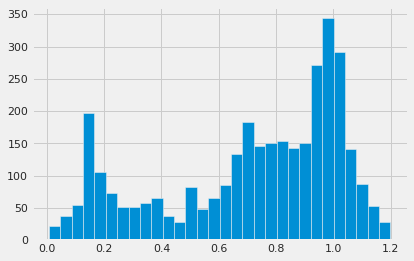

In [95]:
#it seems we have a bimodal distribution. There is a small pick of galaxies relatively close to us, and another cluster far from us
combo_cluster['Mcz'].hist(bins=30)

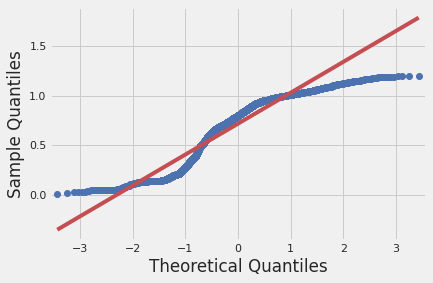

In [96]:
#the shape os the data can be confirmed using this qqplot
qqplot(combo_cluster['Mcz'], line='s')
plt.show()

Let's take the galaxy's distance acording to the group we classified in our BbSCAN cluster.

In [97]:
near_sample = combo_cluster['Mcz'].loc[combo_cluster['dbscan_label']==1]
far_sample = combo_cluster['Mcz'].loc[combo_cluster['dbscan_label']==0]

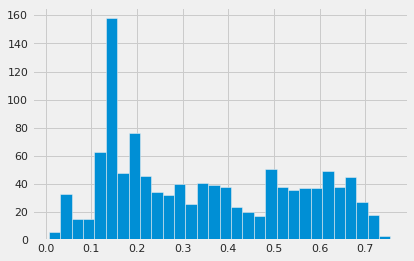

In [98]:
#distribution of galaxies in nearest group acording to DBSCAN
near_sample.hist(bins=30)

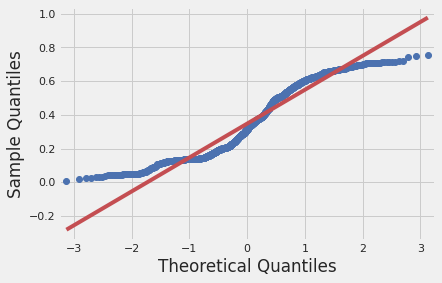

In [99]:
#definitely this is not a normal distribution
qqplot(near_sample, line='s')
plt.show()

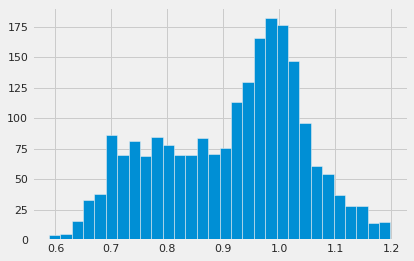

In [100]:
#the far galaxies do not follow the normal distribution two
far_sample.hist(bins=30)

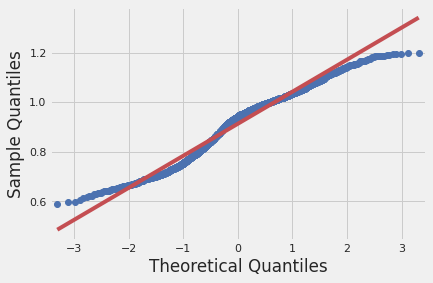

In [101]:
qqplot(far_sample, line='s')
plt.show()

###Non-parametric Data

But how we can compare and how if we can truly considere this galaxies part of different groups or just an misleading of our eyes?

When we do not have a parametric data (normal distributed data) we can use non-parametric tests. There is a long debate about the statistical power of those tests, and when to apply them. Here er have two samples that do not follow the normal distribution, so we cannot compare them using standard deviation and parametric tools. But, we can compare each data is bigger than other (we cannot tell how much each point is bigger or smaler than the other, thi means we lose the magnitude of the difference between them. However, we can certainly tekll each of then is bigger tahn the other). In our casa, where we have a good number of observations (a lot of galaxies), and we want to compare two independent samples, we are able to use the Mann-Whitney non-parametric test.

mann-Withney tells us how much the two groups are separed for each other using the position of each data in a Rank of all the galaxies in our dataset, and not the absolute distance of each galaxy, just like the example before with the t-test. Here we have the steps to find the U-statistics (Mann_Whtney score).

### HYPOTHESIS TEST AND MANN-WHITNEY TEST:
  
  - H0: no difference between the medias of the distance

  - H1: there is a difference between the medians of the distances 

STEP 1: PLACE SAMPLE IN TWO COLUMNS (already done, near_sample, far_sample)

STEP 2: STACK THE THE SAMPLE IN ONE COLUMN RANKED BY THE VALUE (the smaller gets one and the bgger gets (n)

STEP 3: FOR TIED RANKS, SUM THE **POSITION** OF ALL THE THIS TIED DATAS AND GET THEIR AVERAGE.

STEP 4: ASIGN EACH POSITION TO EACH NUMBER THAT YOU RANKED. NOW, INSIDE OF EACH GROUP YOU HAVE THE ABSOLUTE VALUE OF THE GALAXY DISTANCE AND IT'S POSITION N THE RANK.

STEP 5: SUM THE POSITIONS IN THE RANK INSIDE EACH GROUP. IN THE AND YOU WILL HAVE THE SUM OF RANKS FOR NEAR_SAMPLE AND THE SUM OF THE RANKS FOR FAR_SAMPLE

STEP 6: CALCULATE THE U-STATS FOR EACH GROUP USING THE FORMULA:
    
  - U-stats = SUM of the ranks - n(n+1)/2
    
  - Where n is the number of observations inside the sample

STEP 7: CHOOSE THE SMALLEST VALUE AND COMPARE IT TO THE U-CRITICAL FOR YOUR ALPHA LEVEL (0.05 IN THIS CASE). COMPARE the P-VALUE, FOUNDED WITH THE U-CRITICAL WITH YOUR ALPHA LEVEL (0.05)

STEP 8: GET YOUR RESULT


### THE MANN-WHITNEY TEST

In [102]:
stats, p = mannwhitneyu(near_sample, far_sample)

In [103]:
print(stats)
print(f'U-stats: {p}')

10847.5
U-stats: 0.0


With so small P-value we can reject the null-ypothesis, where the assumption is that the distribution of the both groups are identical and there is a 50% probability that an observation from a value ramdonly selected from one population exceeds an observation ramdonly selected from the other population.

This means we are almost sure that this two samples come from a different populatoins of distance from our galaxy.

###BONUS: OUR GALAXY

As you may know, we live in the MILKWAY galaxy. our galaxy is a beautiful blue and barred spiral galaxy. But what if our galaxy could be part of the blue galaxies of teses dataset? Where the MILKWAY would far in the distribution ? Are we more or less brighter than the other galaxies in thee group?

To be able to do that we can just supose the normality of our data, as we did before (using the histogram and the qqplot) and than find the Z-score, wich is how far a value (in this case the MilkWy's Magnitude) is from the mean of the distribution in terms of standard deviation. 

- The Rmag of the Milkway its something around 21, so let's use this value.

In [104]:
#separating our data (The magntude of the galaxies but only the ones from the Label 1 group)
blue = combo_cluster['Rmag'].loc[combo_cluster['dbscan_label']==1]

In [105]:
#just to know:
blue.mean()

22.952280869565204

###Evaluating the normality of the data

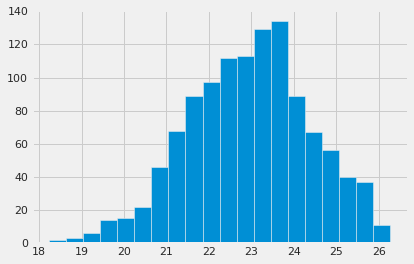

In [106]:
#this kind of seem a normal distributions, with soome distortions and a little bit right skewed.
blue.hist(bins=20)

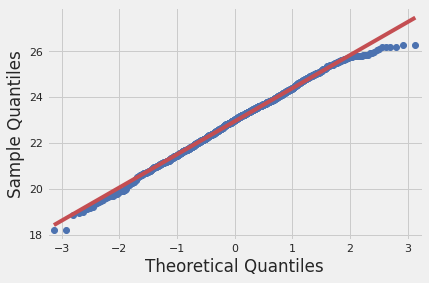

In [107]:
#the qqplot confirms what we thought before with the histogram
qqplot(blue, line='s')
plt.show()

###The Z-Score

In [108]:
#Getting Z-score variables
x = 21 #milkway Rmag
mu = blue.mean() #mean of the distribution
std = stdev(blue) #standard deviation of the sample

In [109]:
# finding the Z-score
z_stats = (x - mu) / std #z-score formula
print(f'Z-Score: {z_stats}')

Z-Score: -1.3518713384539995


Here we have that our galaxy is 1.36 standard deviations units away from the mean, to the left because of the  negative value. But i really want to know how much our galaxy is brighter than the other. And how we have a normal dat we also can have a Probability Density Function, and knowing the Z-score the can just calculate the integral of this value and find the probability of that the value of our galaxy or low by chance inthis sample. Thats also means that the point where our galaxy falls in the distribution tells us how much brighter is the milkway relative to other galaxies in this sample. 

In [110]:
#p-value for left tail 
p_value = scipy.stats.norm.sf(abs(z_stats))
print(f'P-value: {p_value}')

P-value: 0.0882082389174838


So we now know that our galaxy is in the 8.5% brightest gaaxie in this sample. We are preaaty bright and blue, congrats Milkway!


#THE END

Thank you for visit this notebook. Here we travel across the galaxies using some mathematical and statistical tools, and also a litte bit of machine learning. I hope you have liked it! thank you a lot!!
